# TFG: Aplicación de técnicas de aprendizaje automático sobre datos con muestreo irregular
---
# Análisis exploratorio y preparación de los datos
---

**Autor: Javier Caramés Muñoz**

**Universidad de La Laguna**

En este cuaderno, se realiza el estudio previo a la implementación de los modelos, esto comprende desde:
-  Descarga inicial de los conjuntos de datos tanto de frecuencia diaria como operacional
-  Analisis de importancia de variables y relaciones aparentes entre estas.
-  Ingeniería, detección y tratamiento de asincronías e irregularidades temporales
-  Detección y analisis de valores atípicos
-  Gráficos de apoyo o analisis



In [ ]:
pip install seaborn

# Descarga de datos

## Datos de los ciclos operativos
Primero se descarga los ficheros excel que poseen la información de la planta.Estos están dividos en 4 archivos, cada uno comprende un periodo temporal del proyecto.

In [ ]:
import pandas as pd

# Función para limpiar cada DataFrame

def limpiar_df(df):
    # Crear una copia explícita del DataFrame
    df = df.copy()

    # Eliminar filas con 'TOTAL' en la columna 'Time'
    df = df[~df['Time'].astype(str).str.contains('TOTAL', na=False)]

    # Asegurarse de que 'Time' es string
    df['Time'] = df['Time'].astype(str)

    # Convertir correctamente la columna 'Date' a datetime con formato día/mes/año
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

    # Crear columna 'FechaHora' combinando 'Date' y 'Time', y formateando a año-mes-día
    df['FechaHora'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Time'], errors='coerce')

    # Sustituir columna de fechas por 'Date' y eliminar columnas innecesarias
    df['Date'] = df['FechaHora']
    df = df.drop(columns=['FechaHora', 'Time'])

    # Eliminar las últimas 6 filas irrelevantes
    df = df[:-6]

    # Filtrar etapas de inicio de y final de experimento (marzo)
    df = df[df['Date'] >= pd.to_datetime('01-03-2007 00:00:00', dayfirst=True)]
    df = df[df['Date'] <= pd.to_datetime('01-04-2007 00:00:00', dayfirst=True)]

    return df

# Cargar los archivos
df_1 = pd.read_excel('datosfaseI.xlsx', sheet_name=' DataMgr (Wide)')
df_2 = pd.read_excel('datosfaseII.xls', sheet_name=' DataMgr (Wide)')
df_3 = pd.read_excel('datosfaseIII.xls', sheet_name=' DataMgr (Wide)')
df_4 = pd.read_excel('datosfaseIV.xls', sheet_name=' DataMgr (Wide)')

# Limpiar todos los DataFrames
dfs = [df_1, df_2, df_3, df_4]
dfs_limpios = [limpiar_df(df) for df in dfs]

# Eliminar columnas sin nombre del primer DataFrame limpio
dfs_limpios[0] = dfs_limpios[0].loc[:, ~dfs_limpios[0].columns.str.contains('^Unnamed')]

# Concatenar todos los DataFrames limpios en uno solo
df_fases = pd.concat(dfs_limpios, ignore_index=True)

# Conversion de J (ABW) a tipo float ya que estaba en numerico
df_fases['J (ABW)'] = pd.to_numeric(df_fases['J (ABW)'], errors='coerce')

#Archivo con los datos sin tratar y al completo
df_fases.to_csv('datos_fases.csv', index=False)

/tmp/ipython-input-1-2194772460.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_fases = pd.concat(dfs_limpios, ignore_index=True)


##Descarga de dataset diario

A continuación, se descarga el dataset de frecuencia diaria


/tmp/ipython-input-2-3516799390.py:5: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Date (dd:mm:yy)'] = pd.to_datetime(df['Date (dd:mm:yy)'].astype(str), dayfirst=True, errors='coerce')
/tmp/ipython-input-2-3516799390.py:8: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df = df[df['Date (dd:mm:yy)'] >= pd.to_datetime('2006-11-20', dayfirst=True)]


['Date (dd:mm:yy)', 'TSS (mg/L) Feed', 'BOD (mg/L) Feed', 'COD (mg/L) Feed', 'N-Ammonia (mg/L) Feed', 'COD (mg/L) permeado', 'N-Ammonia (mg/L) permeado', 'N-Nitrate (mg/L) permeado', 'MLSS (mg/L) tanque membrana']
Date (dd:mm:yy)                 0.000000
TSS (mg/L) Feed                62.149533
BOD (mg/L) Feed                64.018692
COD (mg/L) Feed                61.214953
N-Ammonia (mg/L) Feed          61.682243
COD (mg/L) permeado            60.280374
N-Ammonia (mg/L) permeado      59.813084
N-Nitrate (mg/L) permeado      61.214953
MLSS (mg/L) tanque membrana    59.813084
dtype: float64


<Axes: >

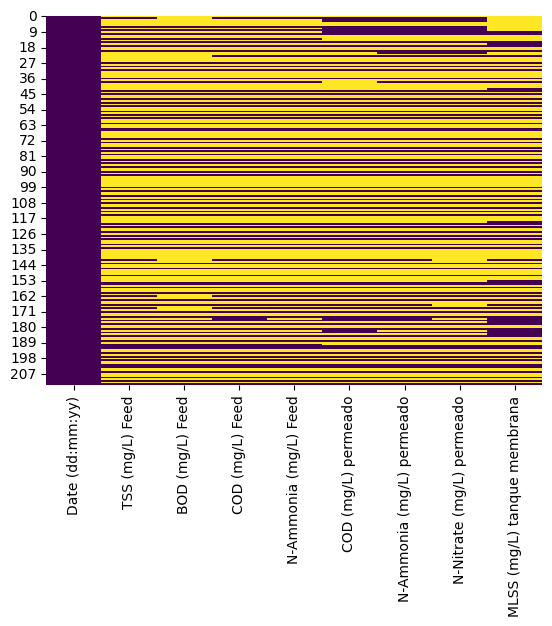

In [ ]:
def limpiar_datos(df):
    df = df.copy()

    # Convertir la columna de fecha
    df['Date (dd:mm:yy)'] = pd.to_datetime(df['Date (dd:mm:yy)'].astype(str), dayfirst=True, errors='coerce')

    # Filtrar fechas desde la Fase I
    df = df[df['Date (dd:mm:yy)'] >= pd.to_datetime('2006-11-20', dayfirst=True)]

    # Lista de columnas que quieres conservar
    columnas_a_conservar = [
        'Date (dd:mm:yy)', 'TSS (mg/L) Feed', 'BOD (mg/L) Feed', 'COD (mg/L) Feed',
        'N-Ammonia (mg/L) Feed', 'COD (mg/L) permeado', 'N-Ammonia (mg/L) permeado',
        'N-Nitrate (mg/L) permeado', 'MLSS (mg/L) tanque membrana'
    ]

    # Filtrar solo las columnas que existan
    columnas_existentes = [col for col in columnas_a_conservar if col in df.columns]
    df = df[columnas_existentes]

    return df

df_diario = pd.read_excel('Analisis_diario.xlsx', sheet_name='Analíticas')
df_diario = limpiar_datos(df_diario)
df_diario.to_csv('datos_diario.csv', index=False)

En este conjunto vemos variables de caracter diario que a pesar de tener gran relevancia observamos que debido a su falta de entradas (>%50 faltante) se ha decidido no tener en cuenta para nuestro estudio

# Análisis inicial

Primero, se analizará los aspectos básicos de las variables como son:


* Correlaciones
* Datos faltantes




Date                                      0.0
Caudal (DBW)                              0.0
FLUX (DBW)                                0.0
J (DBW)                                   0.0
TMP (DBW)                                 0.0
FLUX (ABW)                                0.0
Caudal (ABW)                              0.0
J (ABW)                                   0.0
TMP (ABW)                                 0.0
FLUX (BBW)                                0.0
Caudal (BBW)                              0.0
J (BBW)                                   0.0
TMP (BBW)                                 0.0
System Recovery                           0.0
Minutes of Operation                      0.0
Turbidez (NTU)                            0.0
pH del Permeado                           0.0
Oxígeno disuelto (mg/l)                   0.0
Nivel Tanque aerobio (mm)                 0.0
Nivel Tanque Permeado (mm)                0.0
Nivel Tanque Membranas (mm)               0.0
avail Sludge Wate                 

<Axes: >

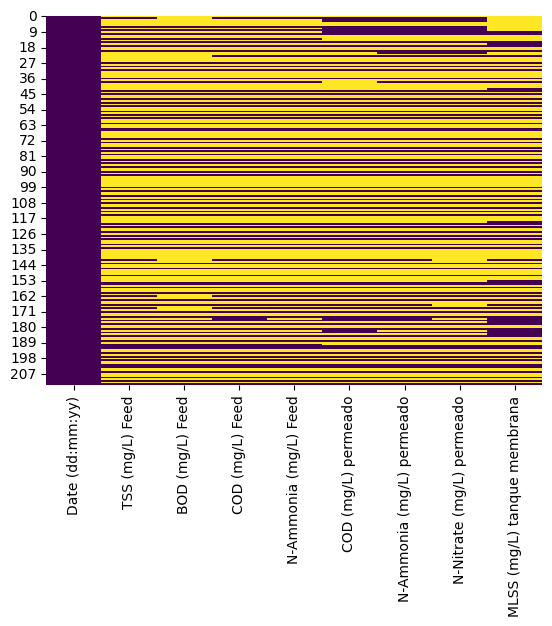

In [ ]:
print(df_fases.isnull().mean() * 100)
print(df_diario.isnull().mean() * 100)

import seaborn as sns
sns.heatmap(df_diario.isnull(), cbar = False, cmap ='viridis')

Como se puede observar, el conjunto de observaciones con frecuencia diaria tiene demasiados valores faltantes como para resultar significativo y útil. Por otro lado, el conjunto de mediciones referentes a los ciclos operacionales no tiene valores faltantes aunque se verá después que esto no es del todo cierto.

A partir de ahora, solo se usará el conjunto de mediciones por ciclos operativos y se descarta por completo el otro.

## Correlaciones
En necesario saber que relaciones hay entre variables de manera inicial para descubrir si hay algunas que sean irrelevantes o redundantes.

Variables redundantes candidatas: ['FLUX (DBW)', 'TMP (DBW)', 'Caudal (ABW)', 'FLUX (BBW)', 'Caudal (BBW)', 'avail Sludge Wate', 'pH del lodo', 'Caudal Recirc. Lodo a membranas (m3/h)', 'Tiempo de BW (s)']


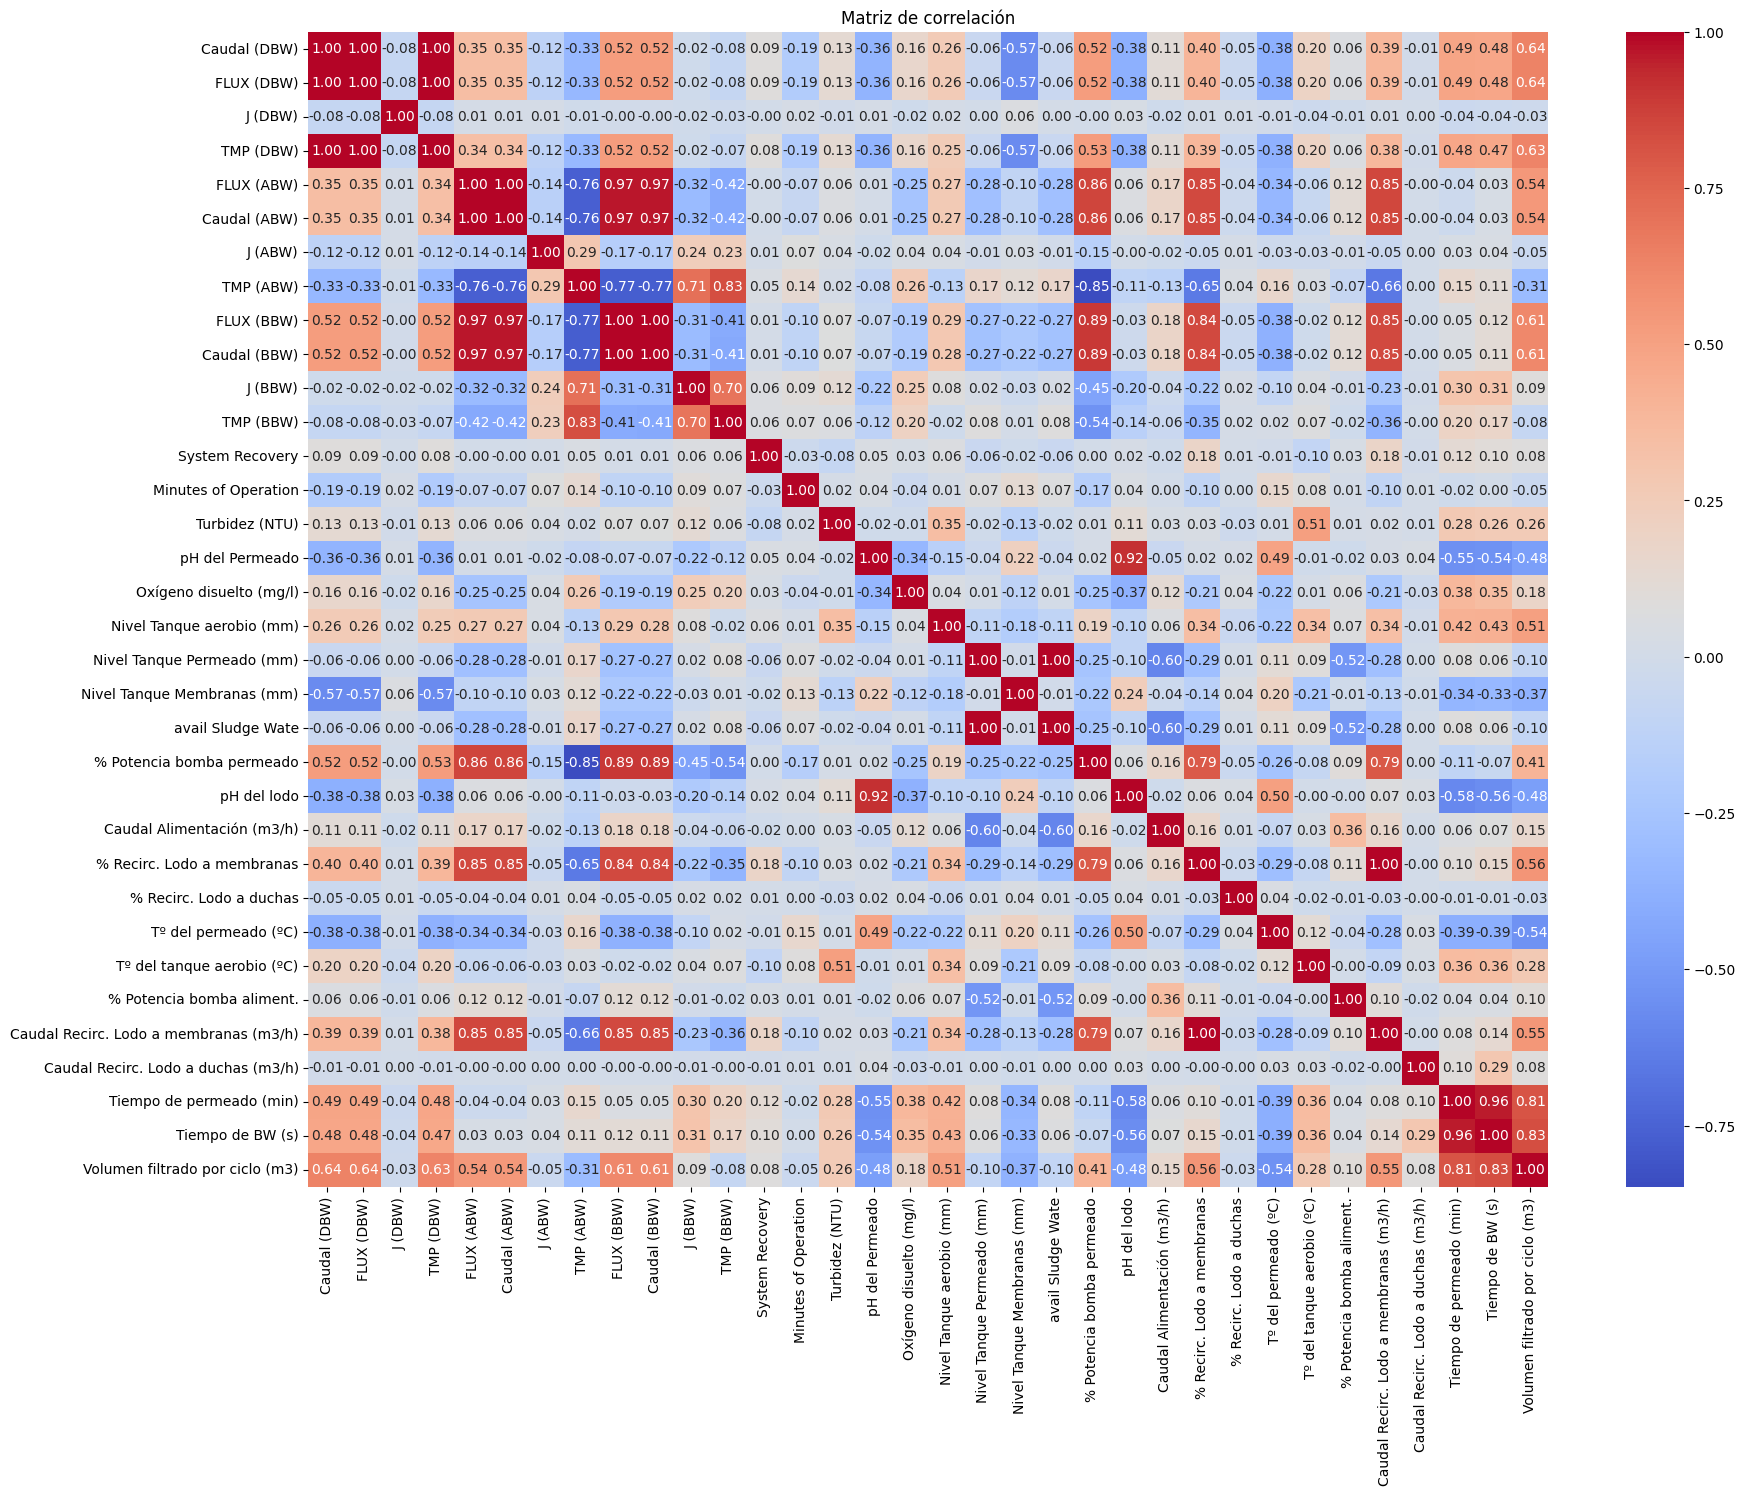

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcular matriz de correlación
corr_matrix = df_fases.corr(numeric_only=True)

# Filtrar pares con correlación fuerte
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Detectar variables redundantes con correlación > 0.9
redundantes = [column for column in upper.columns if any(upper[column] > 0.9) or any (upper[column]<-0.9)]
print("Variables redundantes candidatas:", redundantes)

#Mostrar las correlaciones con un mapa de calor
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

Como se puede observar, existe múltiples variables que se encuentran profundamente relacionadas entre sí:

*  Flujo y caudales (BBW, DBW, ABW)
*  Caudales de recirculación y sus repsectivos porcentajes
*  Nivel de tanque de permeado y Avail Sludge Waste
*  Variables de retrolavado

Con esta información se deciden descartar por:

 tanto los

*   Reduncia: porcentajes de recirculación, caudales (BBW, DBW, ABW), y Avail Sludge Waste
*   Falta de información relativa a la variable: System Recovery
*   Complicaciones operativas, temporales y redundancia: variables con (DDW)




In [ ]:
print(f' Habían',len(df_fases.columns), 'columnas iniciales que son:',df_fases.columns)
# Eliminar columnas no deseadas si existen
columnas_a_dropear = [
        'Caudal (DBW)', 'Caudal (BBW)', 'Caudal (ABW)',
        'FLUX (DBW)', 'J (DBW)', 'TMP (DBW)',
        'System Recovery', 'avail Sludge Wate',
        '% Recirc. Lodo a membranas', '% Recirc. Lodo a duchas',
    ]
df_fases = df_fases.drop(columns=[col for col in columnas_a_dropear if col in df_fases.columns])
print(f'Tras la eliminación de columnas hay un total de',len(df_fases.columns), 'que son: \n', df_fases.columns)

 Habían 25 columnas iniciales que son: Index(['Date', 'FLUX (ABW)', 'J (ABW)', 'TMP (ABW)', 'FLUX (BBW)', 'J (BBW)',
       'TMP (BBW)', 'Minutes of Operation', 'Turbidez (NTU)',
       'pH del Permeado', 'Oxígeno disuelto (mg/l)',
       'Nivel Tanque aerobio (mm)', 'Nivel Tanque Permeado (mm)',
       'Nivel Tanque Membranas (mm)', '% Potencia bomba permeado',
       'pH del lodo', 'Caudal Alimentación (m3/h)', 'Tº del permeado (ºC)',
       'Tº del tanque aerobio (ºC)', '% Potencia bomba aliment.',
       'Caudal Recirc. Lodo a membranas (m3/h)',
       'Caudal Recirc. Lodo a duchas (m3/h)', 'Tiempo de permeado (min)',
       'Tiempo de BW (s)', 'Volumen filtrado por ciclo (m3)'],
      dtype='object')
Tras la eliminación de columnas hay un total de 25 que son: 
 Index(['Date', 'FLUX (ABW)', 'J (ABW)', 'TMP (ABW)', 'FLUX (BBW)', 'J (BBW)',
       'TMP (BBW)', 'Minutes of Operation', 'Turbidez (NTU)',
       'pH del Permeado', 'Oxígeno disuelto (mg/l)',
       'Nivel Tanque aerobio (

## Correlaciones de objetivos
Ahora se ve en detalle las correlaciones con las variables objetivo.

Esto se realiza para comprender de forma más visual la influencia en las variables sobre la presión transmembrana y conseguir una idea previa sobre los mejores candidatos para incluir en los modelos.

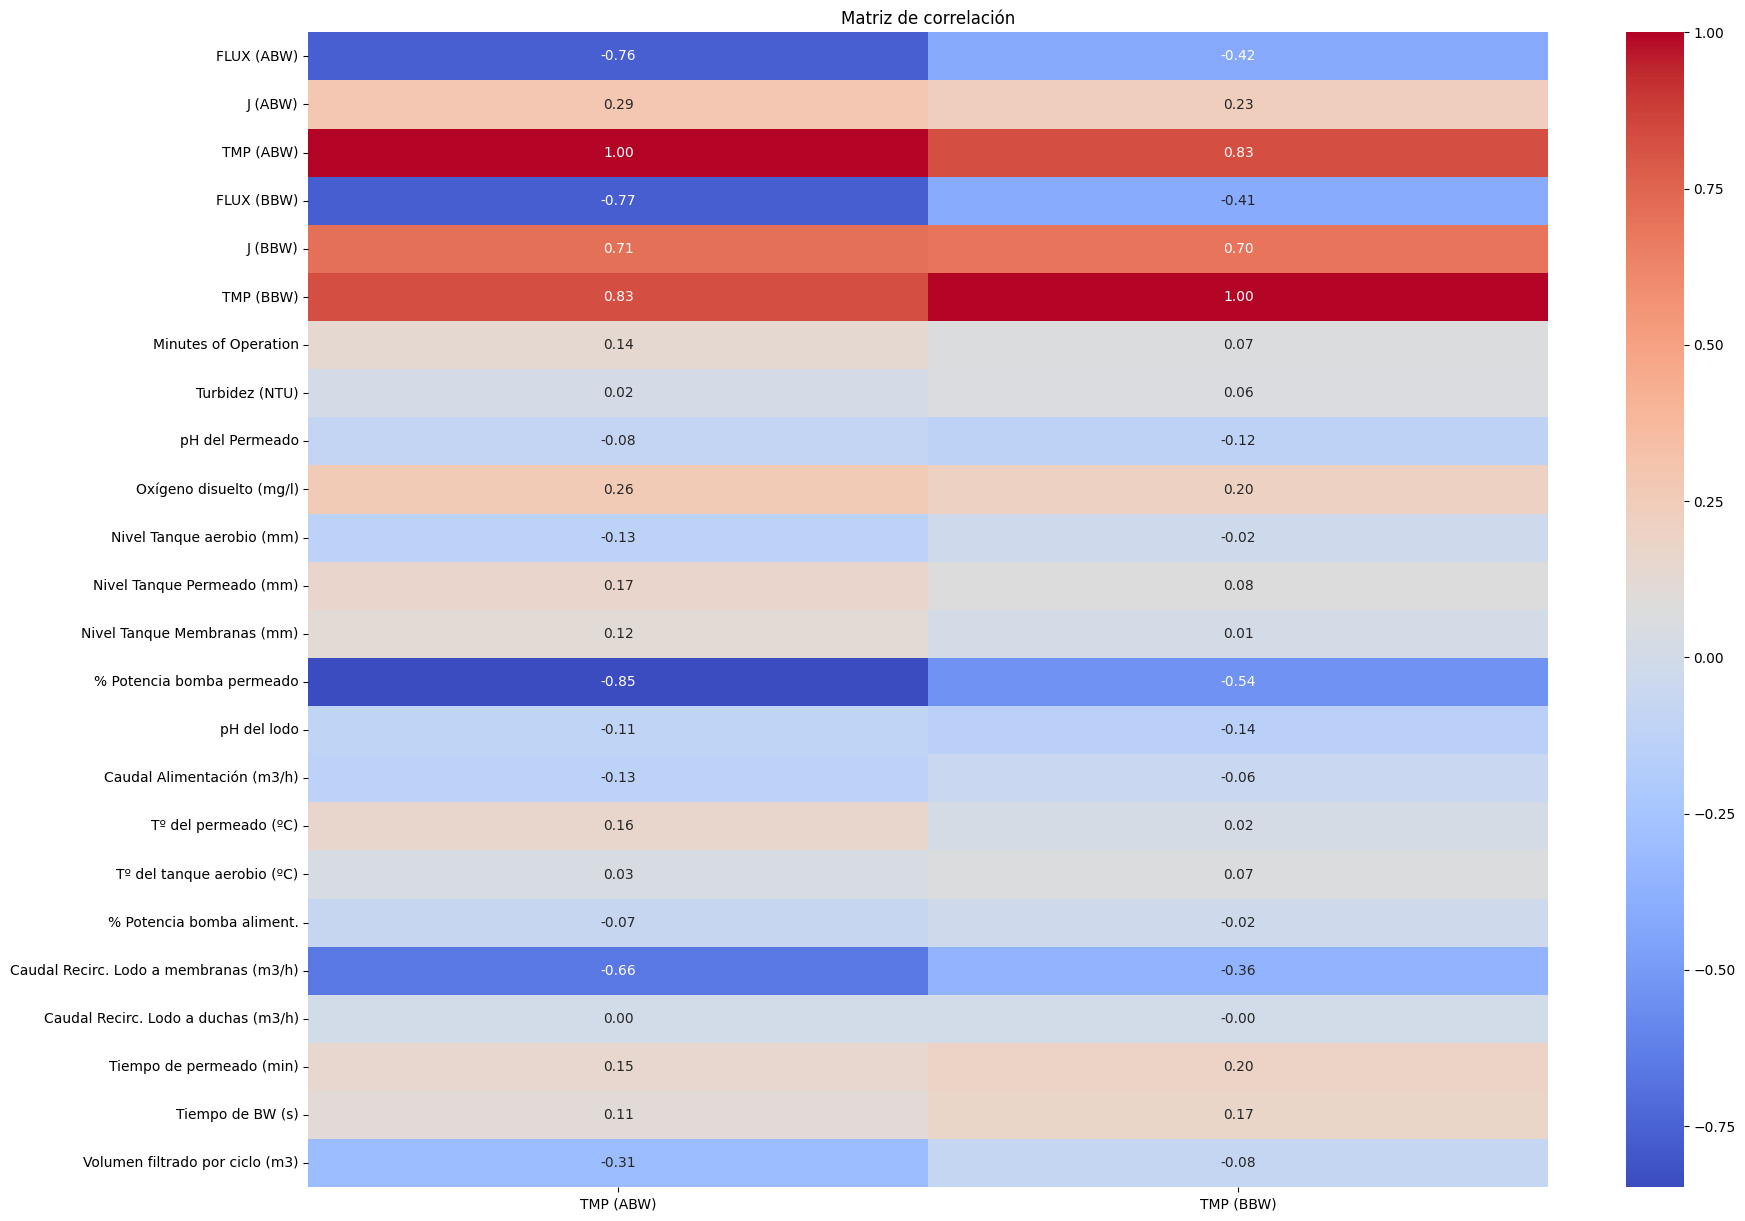

In [ ]:
corr = df_fases.corr(numeric_only=True)[['TMP (ABW)', 'TMP (BBW)', ]]
plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

Las variables más destacadas son:

1.  Variables hidrodinámicas (ABW y BBW).
2.  Bomba de permeado y caudal recirculado a membranas.
3.  Oxígeno, niveles de tanques, minutos de operación y volumen filtrado.
4.  Duración de etapas del ciclo.




# Deteccion de irregularidades e ingenieria de variables

Trabajaremos sobre una copia para asegurarnos que no modificamos el original, en este bloque se analizaran las variables relacionadas con el tiempo y estudiaremos la asincronía e irregularidad crónica del conjunto de datos.

## Ingeniería de variables

In [ ]:
#Creamos una copias para hacer los cambios
df_temp = df_fases.copy()
print(df_fases[(df_fases["Tiempo de BW (s)"] == 0) | (df_temp["Tiempo de permeado (min)"] == 0)][['Tiempo de BW (s)', 'Tiempo de permeado (min)', 'Date']])
# Corregir registros con tiempo de permeado y retrolavado = 0
indices_cero = df_temp[(df_temp["Tiempo de BW (s)"] == 0) | (df_temp["Tiempo de permeado (min)"] == 0)].index

for idx in indices_cero:
    if idx > 0:
        if df_temp.loc[idx - 1, 'Tiempo de permeado (min)']!=0:
          df_temp.loc[idx, 'Tiempo de permeado (min)'] = df_temp.loc[idx - 1, 'Tiempo de permeado (min)']
          df_temp.loc[idx, 'Tiempo de BW (s)'] = df_temp.loc[idx - 1, 'Tiempo de BW (s)']
        else:
          df_temp.loc[idx, 'Tiempo de permeado (min)'] = df_temp.loc[idx + 1, 'Tiempo de permeado (min)']
          df_temp.loc[idx, 'Tiempo de BW (s)'] = df_temp.loc[idx + 1, 'Tiempo de BW (s)']

print(f'Existen un total de', len(indices_cero), 'observaciones con valores nulos de tiempos operativos de ciclo' )

#Reseteo del indice
df_temp = df_temp.reset_index(drop=True)
cero_verif = df_temp[(df_temp["Tiempo de BW (s)"] == 0) | (df_temp["Tiempo de permeado (min)"] == 0)]
print(f'Tras tratamiento existen un total de', len(cero_verif), 'observaciones con valores nulos de tiempos operativos de ciclo' )

      Tiempo de BW (s)  Tiempo de permeado (min)                Date
2819               0.0                       0.0 2007-03-21 08:24:53
2955               0.0                       0.0 2007-03-22 09:20:29
Existen un total de 2 observaciones con valores nulos de tiempos operativos de ciclo
Tras tratamiento existen un total de 0 observaciones con valores nulos de tiempos operativos de ciclo


Tras haber solucionado el problema de tiempo operativos nulos procedemos a estudiarlas un poco mas en detalle estos tiempos, las diferencias temporales entre ciclos consecutivos y el desfase temporal provocando por una toma de datos con retraso respecto al tiempo teórico esperado.


In [ ]:
# 1. Tiempo de ciclo

# 1.1 Pasamos el tiempo de permeado a segundos
df_temp['Tiempo de permeado (s)']=df_temp['Tiempo de permeado (min)']*60
# 1.2 Eliminamos el tiempo de permeado en minutos
df_temp = df_temp.drop(columns=['Tiempo de permeado (min)'])
# 1.3 Calculamos el tiempo de ciclo (permeado + retrolavado)
df_temp['Tiempo de ciclo (s)'] = df_temp['Tiempo de permeado (s)'] + df_temp['Tiempo de BW (s)']

# 2. Creacion de nuevas variables temporales
# 2.1 Variable "Delta_t" - diferencia temporal entre entradas consecutivas
df_temp["Delta_t"] = df_temp["Date"].diff().dt.total_seconds().fillna(0)
# 2.2 Desfase -  diferencia entre el delta_t y el tiempo de ciclo teorico
df_temp["Desfase"] = (df_temp["Delta_t"] - df_temp["Tiempo de ciclo (s)"].shift(1)).fillna(0)

# 2.3 Variables respecto a dias y horas
df_temp["Dia_mes"] = df_temp["Date"].dt.day - 1
df_temp["Dia_semana"] = df_temp["Date"].dt.weekday+1 #(1 = lunes, 7 = domingo)
df_temp["Hora_dia"] = df_temp["Date"].dt.hour

# 3. Eliminar las filas con mismos datestamp
df_temp = df_temp[df_temp['Delta_t'] != 0]

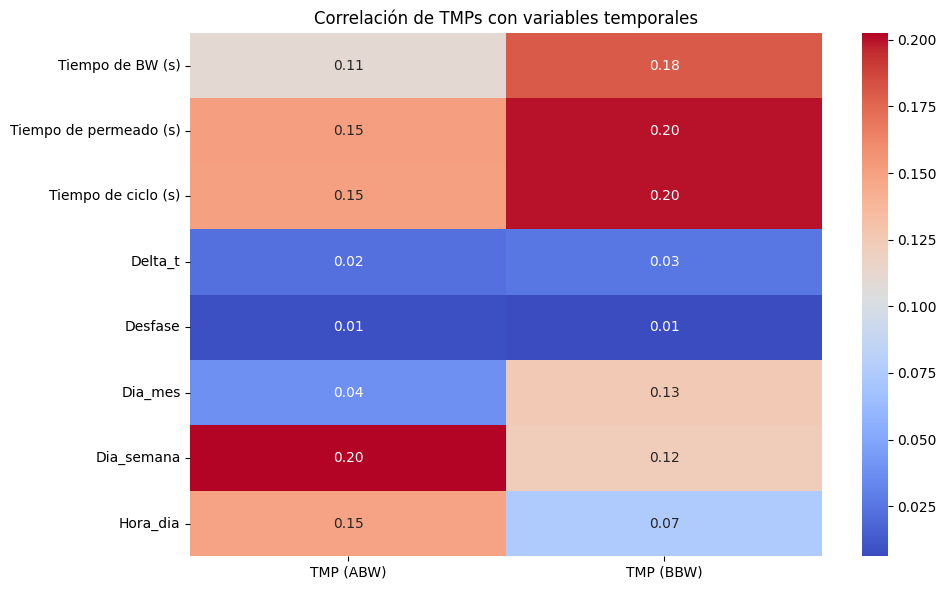

In [ ]:
variables_temp = ['Tiempo de BW (s)', 'Tiempo de permeado (s)', 'Tiempo de ciclo (s)',
                  'Delta_t', 'Desfase', 'Dia_mes', 'Dia_semana', 'Hora_dia']

# Seleccionar solo las variables deseadas + TMPs
cols_interes = variables_temp + ['TMP (ABW)', 'TMP (BBW)']
corr_matrix = df_temp[cols_interes].corr(numeric_only=True)

# Filtrar solo filas correspondientes a variables_temp y columnas TMPs
corr_filtrada = corr_matrix.loc[variables_temp, ['TMP (ABW)', 'TMP (BBW)']]

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(corr_filtrada, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlación de TMPs con variables temporales")
plt.tight_layout()
plt.show()


Como podemos observar, las nuevas variables temporales no poseen una relación lineal directa con las variables objetivas pero que si existen relaciones mas profundas y no lineales. Ahora analisa

## Detección de irregularidades temporales (Desfase):

Primero se vera como se comporta la variable de desfase

CV: 0.0732988520773235
p-value: 2.069200896712336e-90
       lb_stat     lb_pvalue
20  173.045206  2.214029e-26


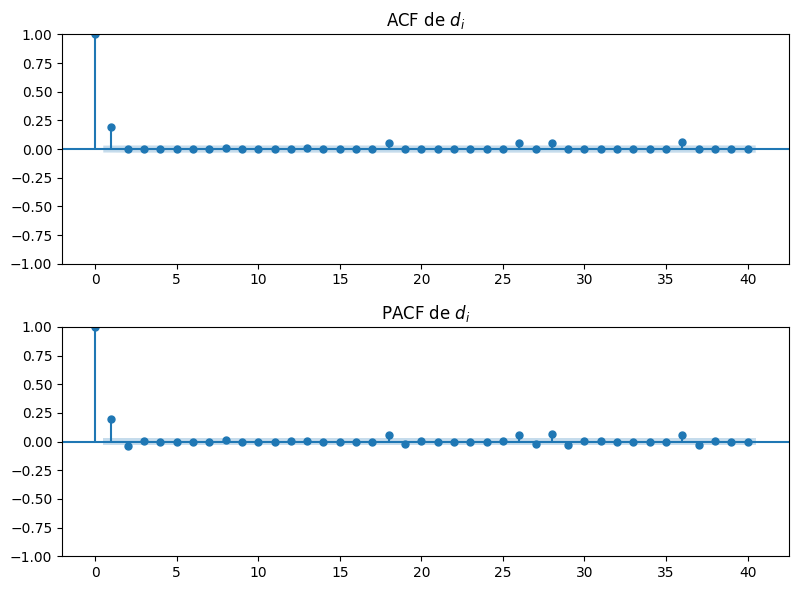

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

#Stats basicas
df_temp['Desfase'].describe()

#Coeficiente de variacion
cv = df_temp['Desfase'].mean() / df_temp['Desfase'].std()
print(f'CV: {cv}')

#Test de shapiro
w, p = stats.shapiro(df_temp['Desfase'])
print(f'p-value: {p}')

#Ljung-Box
lb = acorr_ljungbox(df_temp['Desfase'].dropna(), lags=[20], return_df=True)
print(lb)      # columnas: lb_stat, lb_pvalue

#ACF & PACF
fig, ax = plt.subplots(2, 1, figsize=(8,6))
sm.graphics.tsa.plot_acf(df_temp['Desfase'].dropna(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(df_temp['Desfase'].dropna(), lags=40, ax=ax[1], method='ywm')
ax[0].set_title('ACF de $d_i$');   ax[1].set_title('PACF de $d_i$')
plt.tight_layout()
plt.show()

Tras ....
Vamos a estudiar los valores negativos....

## Tratamiento de irregularidades
En este bloque se tratan los valores visto anteriormente debido a su inconsistencia e interferencia con valores con mayor calidad de toma.

In [ ]:
# — Parámetros fijos ——————————————————————————————
EPS      = 0.02     # ±2 %
TH_PROP  = 0.75     # 75 %
DELTA    = 1e-6     # evita /0
df_temp  = df_temp.sort_values('Date').reset_index(drop=True)

# Identificar observaciones con Desfase < 0 (tal como hacías)
indices_neg = df_temp[df_temp["Desfase"] < 0].index

# — Inicializar contadores ————————————————————————
conteo_dup  = conteo_corto = conteo_tijera = conteo_otros = 0
list_dup, list_corto, list_tijera, list_otros = [], [], [], []
total_analizadas = 0

# Columnas numéricas a comparar (todas salvo la fecha)
num_cols = [c for c in df_temp.columns
            if c != "Date" and pd.api.types.is_numeric_dtype(df_temp[c])]

# — Bucle principal ————————————————————————————————
for idx in indices_neg:
    if idx == 0 or idx == len(df_temp) - 1:
        continue                      # necesita vecinos a ambos lados

    total_analizadas += 1
    row       = df_temp.loc[idx]
    prev_row  = df_temp.loc[idx - 1]
    next_row  = df_temp.loc[idx + 1]

    fecha_prev  = prev_row["Date"]
    fecha_actual = row["Date"]
    fecha_next  = next_row["Date"]

    ciclo_prev  = prev_row['Tiempo de ciclo (s)']
    ciclo_act   = row['Tiempo de ciclo (s)']
    ciclo_next  = next_row['Tiempo de ciclo (s)']

    # — (i) Duplicado: unión de similitudes con prev / next ————————
    iguales_union = 0
    for col in num_cols:
        # cambio relativo con respecto a prev y next
        rel_prev = abs(row[col] - prev_row[col]) / (max(abs(row[col]), abs(prev_row[col])) + DELTA)
        rel_next = abs(row[col] - next_row[col]) / (max(abs(row[col]), abs(next_row[col])) + DELTA)
        if (rel_prev < EPS) or (rel_next < EPS):
            iguales_union += 1

    pct_union = iguales_union / len(num_cols)

    # — (ii) Ciclo demasiado corto ————————————————
    dt_prev = (fecha_actual - fecha_prev).total_seconds()
    corto   = dt_prev < 0.45 * ciclo_prev      # 45 % del ciclo anterior

    # — (iii) Tijera interna ——————————————
    dt_scissor = (fecha_next - fecha_prev).total_seconds()
    umbral_scissor = 1.15 * max(ciclo_prev, ciclo_next)   # 115 % del mayor de los dos
    tijera = dt_scissor < umbral_scissor

    # — Clasificación final —————————————————————
    if pct_union >= TH_PROP:
        conteo_dup += 1
        list_dup.append(idx)
    elif corto:
        conteo_corto += 1
        list_corto.append(idx)
    elif tijera:
        conteo_tijera += 1
        list_tijera.append(idx)
    else:
        conteo_otros += 1
        list_otros.append(idx)

# — Resumen de porcentajes ——————————————————————————
irregularidades = {
    "Duplicado ≥75%":           100 * conteo_dup    / total_analizadas,
    "Ciclo <15% del anterior":  100 * conteo_corto  / total_analizadas,
    "Tijera interna":           100 * conteo_tijera / total_analizadas,
    "Otros":                    100 * conteo_otros  / total_analizadas,
    "Total analizadas":         total_analizadas
}

print(irregularidades)


{'Duplicado ≥75%': 59.701492537313435, 'Ciclo <15% del anterior': 13.432835820895523, 'Tijera interna': 0.0, 'Otros': 26.865671641791046, 'Total analizadas': 67}


In [ ]:
to_drop = list_dup + list_corto + list_tijera
df_temp = df_temp.drop(to_drop).reset_index(drop=True)

#Recalculo de desfases y tiempos transcurridos
# 2.1 Variable "Delta_t" - diferencia temporal entre entradas consecutivas
df_temp["Delta_t"] = df_temp["Date"].diff().dt.total_seconds().fillna(0)
# 2.2 Desfase -  diferencia entre el delta_t y el tiempo de ciclo teorico
df_temp["Desfase"] = (df_temp["Delta_t"] - df_temp["Tiempo de ciclo (s)"].shift(1)).fillna(0)
df_temp.columns

Index(['Date', 'Caudal (DBW)', 'FLUX (DBW)', 'J (DBW)', 'TMP (DBW)',
       'FLUX (ABW)', 'Caudal (ABW)', 'J (ABW)', 'TMP (ABW)', 'FLUX (BBW)',
       'Caudal (BBW)', 'J (BBW)', 'TMP (BBW)', 'System Recovery',
       'Minutes of Operation', 'Turbidez (NTU)', 'pH del Permeado',
       'Oxígeno disuelto (mg/l)', 'Nivel Tanque aerobio (mm)',
       'Nivel Tanque Permeado (mm)', 'Nivel Tanque Membranas (mm)',
       'avail Sludge Wate', '% Potencia bomba permeado', 'pH del lodo',
       'Caudal Alimentación (m3/h)', '% Recirc. Lodo a membranas',
       '% Recirc. Lodo a duchas', 'Tº del permeado (ºC)',
       'Tº del tanque aerobio (ºC)', '% Potencia bomba aliment.',
       'Caudal Recirc. Lodo a membranas (m3/h)',
       'Caudal Recirc. Lodo a duchas (m3/h)', 'Tiempo de BW (s)',
       'Volumen filtrado por ciclo (m3)', 'Tiempo de permeado (s)',
       'Tiempo de ciclo (s)', 'Delta_t', 'Desfase', 'Dia_mes', 'Dia_semana',
       'Hora_dia'],
      dtype='object')

In [ ]:
df_temp[df_temp["Desfase"]<0]

Date  Caudal (DBW)  FLUX (DBW)  J (DBW)  TMP (DBW)  \
746  2007-03-05 08:12:03          0.01        0.22    98.79       0.22   
1745 2007-03-12 07:18:37          0.04        0.69  1037.74      -0.07   
2056 2007-03-14 18:09:49          0.05        0.75   485.79      -0.15   
2373 2007-03-17 05:07:55          2.49       39.79   454.35       8.76   
3245 2007-03-24 22:19:56          0.02        0.33   974.34       0.03   
3914 2007-03-30 02:16:27          0.04        0.60  1290.10       0.05   

      FLUX (ABW)  Caudal (ABW)  J (ABW)  TMP (ABW)  FLUX (BBW)  ...  \
746        15.04          0.94   437.68      -3.44       15.75  ...   
1745       24.41          1.53   495.20      -4.93       23.85  ...   
2056       24.11          1.51   450.17      -5.36       24.95  ...   
2373       29.51          1.85   479.37      -6.16       32.18  ...   
3245       25.23          1.58   529.72      -4.76       25.78  ...   
3914       22.60          1.42   480.05      -4.71       22.85  ...   

      Caudal Recirc. Lodo a duchas (m3/h)  Tiempo de BW (s)  \
746                                   8.0              30.0   
1745                                  8.0              35.0   
2056                                  8.0              35.0   
2373                                  8.0              35.0   
3245                                  8.0              35.0   
3914                                  8.0              35.0   

      Volumen filtrado por ciclo (m3)  Tiempo de permeado (s)  \
746                          0.096500                   360.0   
1745                         0.247500                   600.0   
2056                         0.255000                   600.0   
2373                         0.297458                   600.0   
3245                         0.265833                   600.0   
3914                         0.237500                   600.0   

      Tiempo de ciclo (s)  Delta_t  Desfase  Dia_mes  Dia_semana  Hora_dia  
746                 390.0    361.0    -29.0        4           1         8  
1745                635.0    601.0    -34.0       11           1         7  
2056                635.0    602.0    -33.0       13           3        18  
2373                635.0    581.0    -54.0       16           6         5  
3245                635.0    601.0    -34.0       23           6        22  
3914                635.0    601.0    -34.0       29           5         2  

[6 rows x 41 columns]

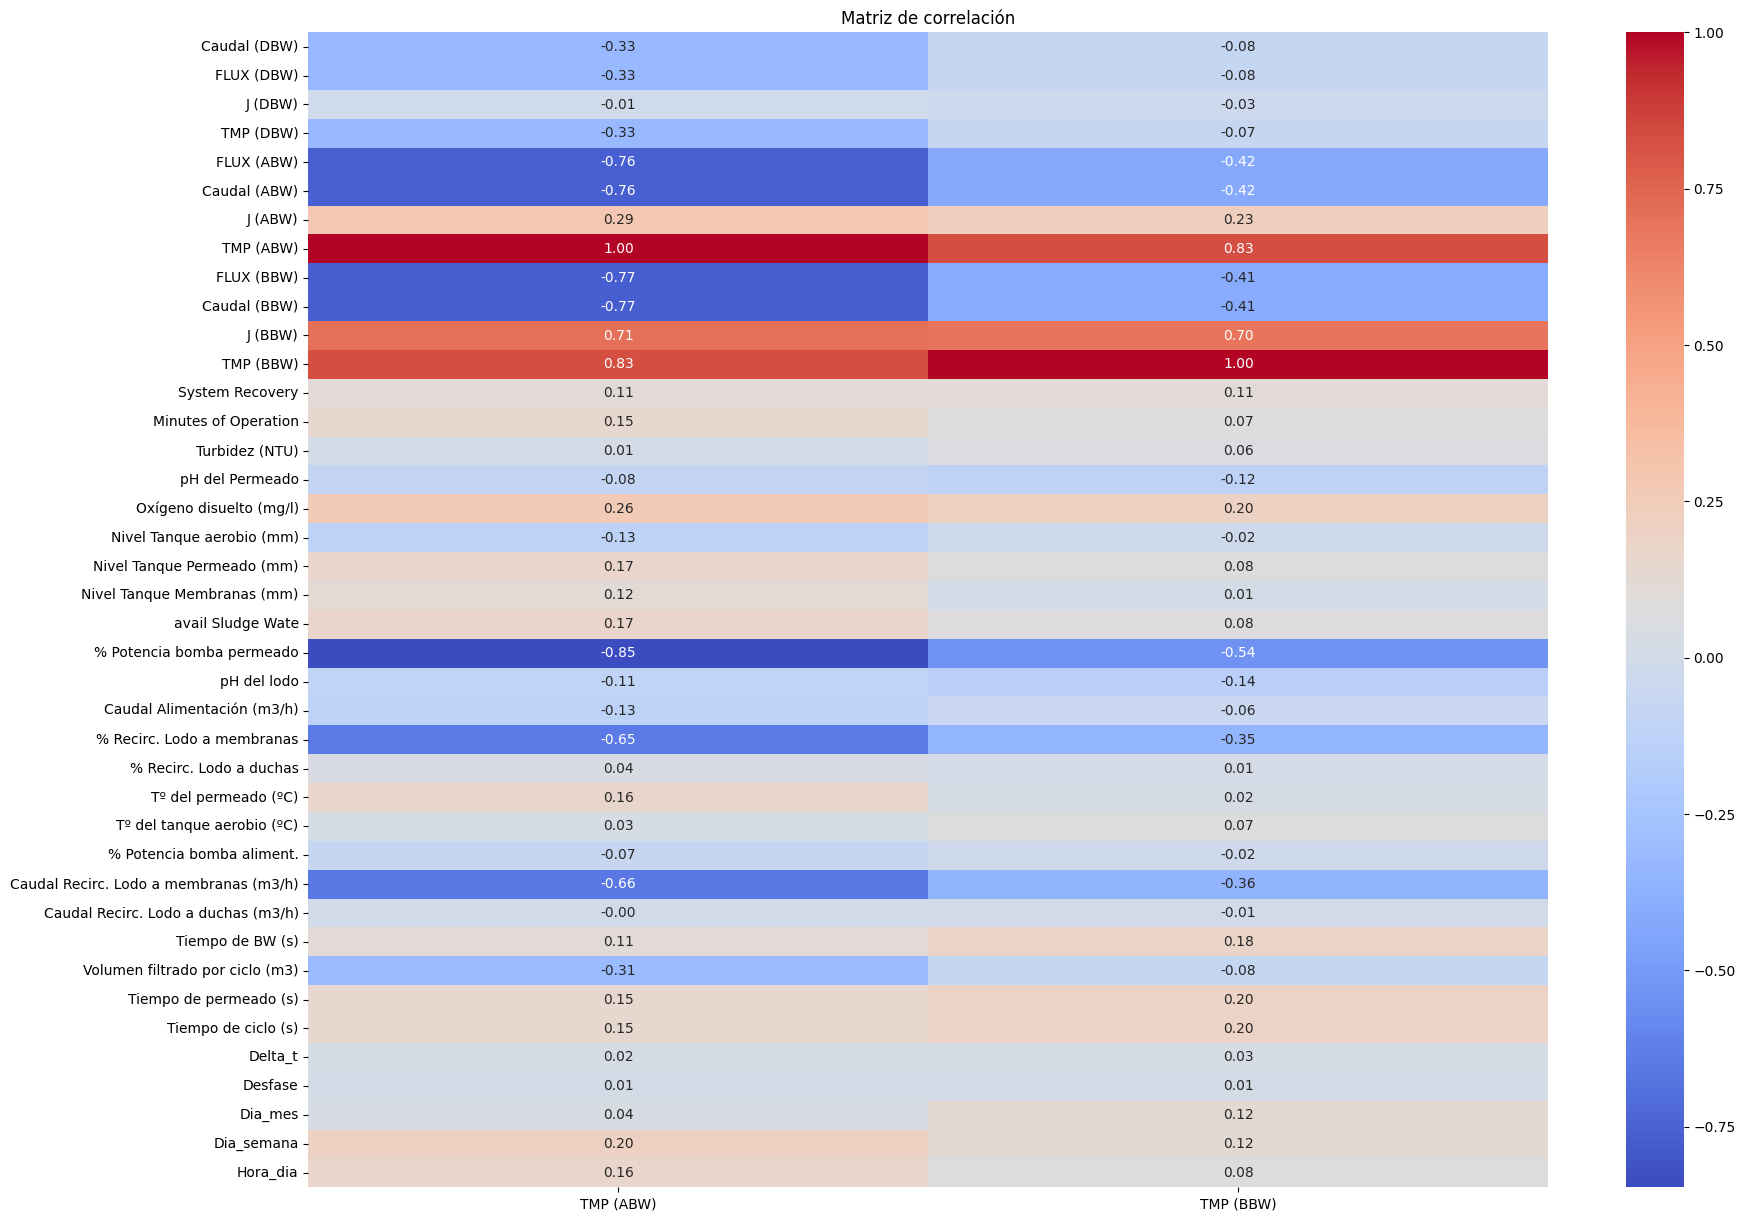

In [ ]:
corr = df_temp.corr(numeric_only=True)[['TMP (ABW)', 'TMP (BBW)']]
plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

#Detección de outliers

A continuación trataremos con los valores atipicos o ouliers presentes en todas las variables y cuya caracterististicas y naturaleza influyen en gran medida en el modelo tanto a favor como en contra. Hemos decidio designar como eventos a elimar aquellos que son externos al funcionamiento normal del sistema como cortes eléctricos o fenomenos naturales (lluvias extremas). Por otro lado se han designado como valores aceptables aquellos asociados a fallos de equipos normales, problemas operativos, mantenimientos, calibraciones de semsores, etc.

La lógica principal es que los eventos externos que interrumpen completamente el funcionamiento (como cortes eléctricos o fenómenos naturales extremos) deberían considerarse outliers ya que no representan el rendimiento real del sistema bajo condiciones operativas normales. Los demás problemas, aunque sean incidencias, son parte del comportamiento normal esperado del sistema y proporcionan información valiosa sobre su rendimiento.

Primero descartamos por completo la variable J DBW ya que no es práctica y de los valores J solo son realisstas si están entre 0 y 1000

In [ ]:
df_outlier = df_temp.copy()
df_outlier.describe().T

count                           mean  \
Date                                      4165  2007-03-15 14:29:17.011524608   
Caudal (DBW)                            4165.0                       0.795561   
FLUX (DBW)                              4165.0                      12.697573   
J (DBW)                                 4165.0                    1370.699534   
TMP (DBW)                               4165.0                       2.926634   
FLUX (ABW)                              4165.0                      26.687128   
Caudal (ABW)                            4165.0                       1.672149   
J (ABW)                                 4165.0                     459.327054   
TMP (ABW)                               4165.0                      -6.015181   
FLUX (BBW)                              4165.0                      27.632905   
Caudal (BBW)                            4165.0                       1.731383   
J (BBW)                                 4165.0                     478.869575   
TMP (BBW)                               4165.0                      -6.249092   
System Recovery                         4165.0                      630.51861   
Minutes of Operation                    4165.0                     713.115246   
Turbidez (NTU)                          4165.0                       0.049006   
pH del Permeado                         4165.0                       7.713491   
Oxígeno disuelto (mg/l)                 4165.0                       0.522269   
Nivel Tanque aerobio (mm)               4165.0                    2376.419676   
Nivel Tanque Permeado (mm)              4165.0                    2088.023914   
Nivel Tanque Membranas (mm)             4165.0                     1080.12776   
avail Sludge Wate                       4165.0                    1956.270336   
% Potencia bomba permeado               4165.0                      33.158463   
pH del lodo                             4165.0                       7.527047   
Caudal Alimentación (m3/h)              4165.0                       1.553911   
% Recirc. Lodo a membranas              4165.0                      77.144298   
% Recirc. Lodo a duchas                 4165.0                        99.9503   
Tº del permeado (ºC)                    4165.0                      24.963541   
Tº del tanque aerobio (ºC)              4165.0                       31.17388   
% Potencia bomba aliment.               4165.0                      38.866987   
Caudal Recirc. Lodo a membranas (m3/h)  4165.0                      10.836096   
Caudal Recirc. Lodo a duchas (m3/h)     4165.0                       7.998079   
Tiempo de BW (s)                        4165.0                       33.19928   
Volumen filtrado por ciclo (m3)         4165.0                       0.236397   
Tiempo de permeado (s)                  4165.0                     515.812725   
Tiempo de ciclo (s)                     4165.0                     549.012005   
Delta_t                                 4165.0                     643.003121   
Desfase                                 4165.0                      94.143577   
Dia_mes                                 4165.0                       14.10036   
Dia_semana                              4165.0                       4.108764   
Hora_dia                                4165.0                      11.578631   

                                                        min  \
Date                                    2007-03-01 00:00:18   
Caudal (DBW)                                            0.0   
FLUX (DBW)                                              0.0   
J (DBW)                                                 0.0   
TMP (DBW)                                             -1.29   
FLUX (ABW)                                              0.4   
Caudal (ABW)                                           0.03   
J (ABW)                                              157.86   
TMP (ABW)                                             -19.1   
FLUX (BB

In [ ]:
df_outlier[(df_outlier["J (ABW)"] > 1000) | (df_outlier["J (BBW)"] > 1000)]

CAP_J = 1000  # límite superior físico razonable

# --- crea banderas de winsorización ----------------------------
df_outlier['J_cap_ABW'] = (df_outlier['J (ABW)'] > CAP_J).astype(int)
df_outlier['J_cap_BBW'] = (df_outlier['J (BBW)'] > CAP_J).astype(int)

# --- aplica winsorización in-place ------------------------------
df_outlier['J (ABW)'] = df_outlier['J (ABW)'].clip(upper=CAP_J)
df_outlier['J (BBW)'] = df_outlier['J (BBW)'].clip(upper=CAP_J)

# --- (opcional) imprime cuántos puntos fueron recortados --------
n_abw = df_outlier['J_cap_ABW'].sum()
n_bbw = df_outlier['J_cap_BBW'].sum()
print(f"Winsorizados ABW: {n_abw}  |  Winsorizados BBW: {n_bbw}")


Winsorizados ABW: 2  |  Winsorizados BBW: 2


# Descarga de archivos final


In [ ]:
df_outlier.to_csv('datos_marzof.csv', index=False)

#Creacion de graficos

In [ ]:
import pandas as pd

df_marzo = pd.read_csv('datos_marzof.csv')

## Graficos de evolucion temporal de FLUX, J y TMP
Esta subsección se compone de 5 conjuntos de graficos


*   TMP ABW vs BBW
*   TMPs vs FLUXs vs Js
*   TMPs vs niveles de tanques
*   TMPs vs caudales
*   TMPs vs temperaturas y bombas
*   TMPs vs pHs, Oxígeno y Turbidez




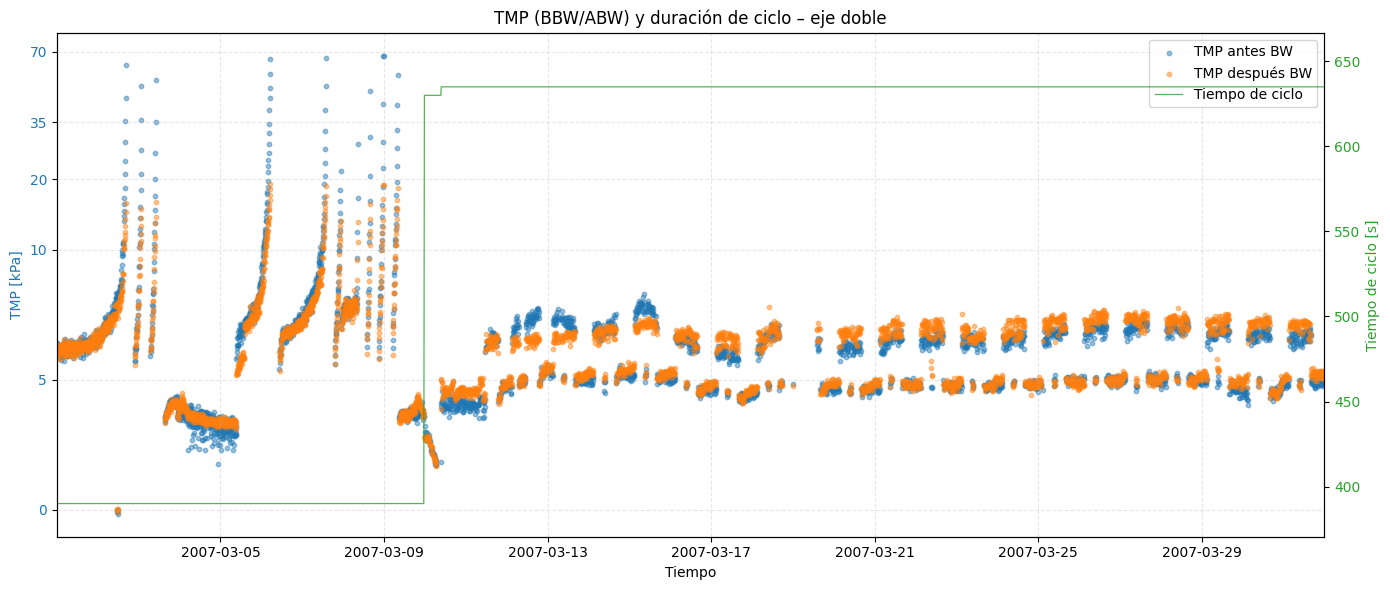

In [ ]:
import matplotlib.pyplot as plt

df = df_outlier.copy()
fecha_min, fecha_max = df['Date'].min(), df['Date'].max()

# ─── Figura y eje izquierdo ───────────────────────────────────────────────
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.scatter(df['Date'], -df['TMP (BBW)'], s=10, alpha=0.45,
            label='TMP antes BW',  color='tab:blue')
ax1.scatter(df['Date'], -df['TMP (ABW)'], s=10, alpha=0.45,
            label='TMP después BW', color='tab:orange')

# escala symlog para abrir la zona 0-20 kPa
ax1.set_yscale('symlog', linthresh=10, linscale=1)
ax1.set_yticks([0, 5, 10, 20, 35, 70])
ax1.get_yaxis().set_major_formatter('{x:.0f}')
ax1.set_ylabel('TMP [kPa]', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# ─── Eje derecho: tiempo de ciclo ─────────────────────────────────────────
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['Tiempo de ciclo (s)'], lw=0.9, alpha=0.8,
         color='tab:green', label='Tiempo de ciclo')
ax2.set_ylabel('Tiempo de ciclo [s]', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.set_ylim(df['Tiempo de ciclo (s)'].min()*0.95,
             df['Tiempo de ciclo (s)'].max()*1.05)

# ─── Eje x, leyenda, rejilla ─────────────────────────────────────────────
ax1.set_xlim(fecha_min, fecha_max)
ax1.set_xlabel('Tiempo')
ax1.grid(True, ls='--', alpha=0.3)

# combinar leyendas de ambos ejes
lines = ax1.get_lines() + ax1.collections   # scatter devuelto como collection
labels = [l.get_label() for l in lines]
lines2 = ax2.get_lines()
labels2 = [l.get_label() for l in lines2]
ax1.legend(lines + lines2, labels + labels2, loc='upper right')
plt.title('TMP (BBW/ABW) y duración de ciclo – eje doble')
plt.tight_layout()
plt.show()


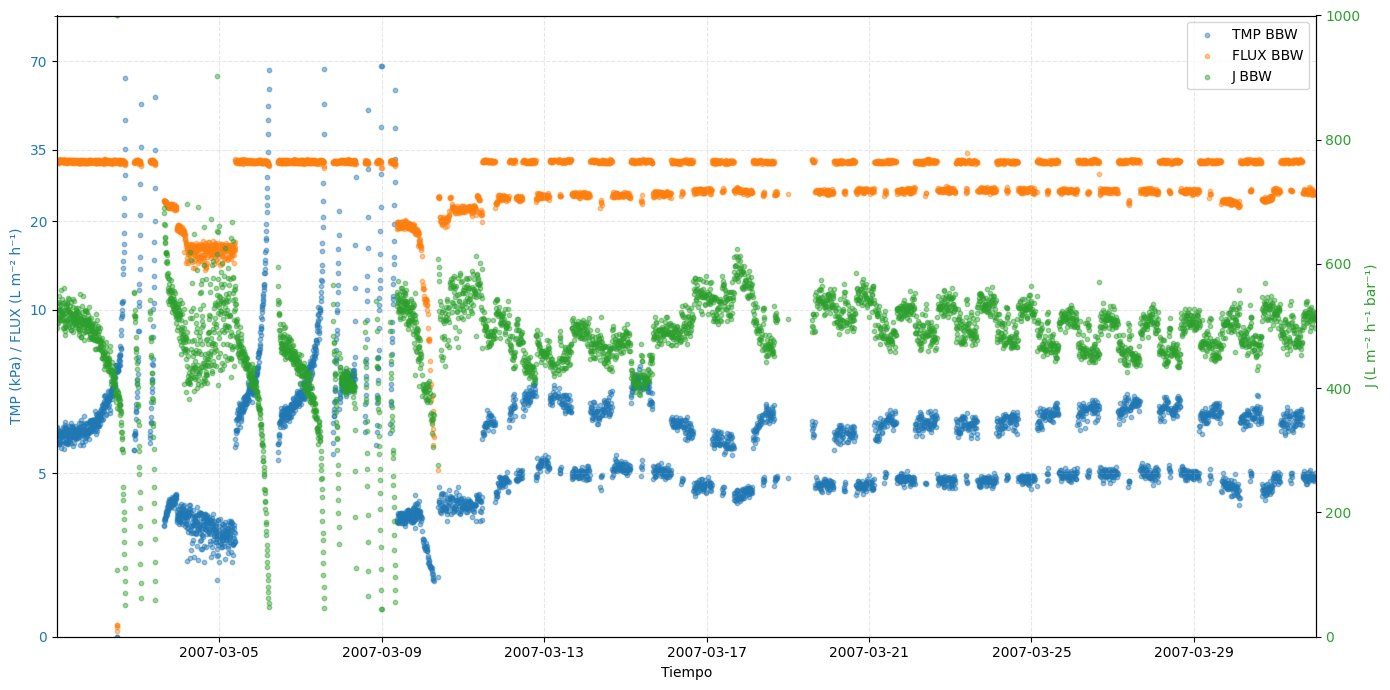

In [ ]:
import matplotlib.pyplot as plt

# Datos y rangos comunes
#df = df_outlier.copy()
fecha_min, fecha_max = df['Date'].min(), df['Date'].max()
LEFT_LIM, RIGHT_LIM = (0, 100), (0, 1000)
LEFT_TICKS = [0, 5, 10, 20, 35, 70]

# Figura para fase BBW
phase = 'BBW'
fig, ax1 = plt.subplots(figsize=(14, 7))

# Eje izquierdo: TMP y FLUX
ax1.scatter(df['Date'], -df[f'TMP ({phase})'],
            s=10, alpha=0.45, label=f'TMP {phase}', color='tab:blue')
ax1.scatter(df['Date'],  df[f'FLUX ({phase})'],
            s=10, alpha=0.45, label=f'FLUX {phase}', color='tab:orange')

ax1.set_yscale('symlog', linthresh=10, linscale=1)
ax1.set_yticks(LEFT_TICKS)
ax1.get_yaxis().set_major_formatter('{x:.0f}')
ax1.set_ylim(*LEFT_LIM)
ax1.set_ylabel('TMP (kPa) / FLUX (L m⁻² h⁻¹)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, ls='--', alpha=0.3)

# Eje derecho: J
ax2 = ax1.twinx()
ax2.scatter(df['Date'], df[f'J ({phase})'],
            s=10, alpha=0.45, label=f'J {phase}', color='tab:green')
ax2.set_ylim(*RIGHT_LIM)
ax2.set_ylabel('J (L m⁻² h⁻¹ bar⁻¹)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper right')

# Ajustes finales
ax1.set_xlabel('Tiempo')
ax1.set_xlim(fecha_min, fecha_max)
plt.tight_layout()
plt.show()


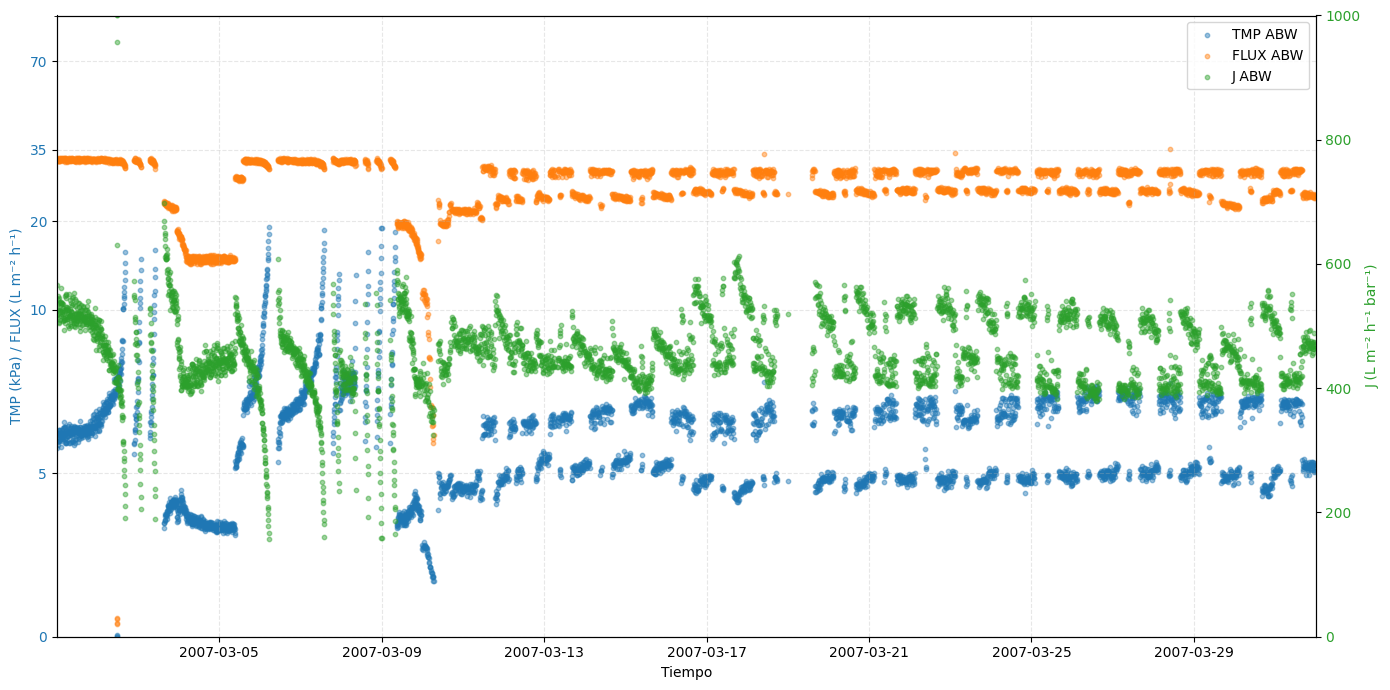

In [ ]:
import matplotlib.pyplot as plt

# Datos y rangos comunes
df = df_outlier.copy()
fecha_min, fecha_max = df['Date'].min(), df['Date'].max()
LEFT_LIM, RIGHT_LIM = (0, 100), (0, 1000)
LEFT_TICKS = [0, 5, 10, 20, 35, 70]

# Figura para fase ABW
phase = 'ABW'
fig, ax1 = plt.subplots(figsize=(14, 7))

# Eje izquierdo: TMP y FLUX
ax1.scatter(df['Date'], -df[f'TMP ({phase})'],
            s=10, alpha=0.45, label=f'TMP {phase}', color='tab:blue')
ax1.scatter(df['Date'],  df[f'FLUX ({phase})'],
            s=10, alpha=0.45, label=f'FLUX {phase}', color='tab:orange')

ax1.set_yscale('symlog', linthresh=10, linscale=1)
ax1.set_yticks(LEFT_TICKS)
ax1.get_yaxis().set_major_formatter('{x:.0f}')
ax1.set_ylim(*LEFT_LIM)
ax1.set_ylabel('TMP (kPa) / FLUX (L m⁻² h⁻¹)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, ls='--', alpha=0.3)

# Eje derecho: J
ax2 = ax1.twinx()
ax2.scatter(df['Date'], df[f'J ({phase})'],
            s=10, alpha=0.45, label=f'J {phase}', color='tab:green')
ax2.set_ylim(*RIGHT_LIM)
ax2.set_ylabel('J (L m⁻² h⁻¹ bar⁻¹)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper right')

# Ajustes finales
ax1.set_xlabel('Tiempo')
ax1.set_xlim(fecha_min, fecha_max)
plt.tight_layout()
plt.show()


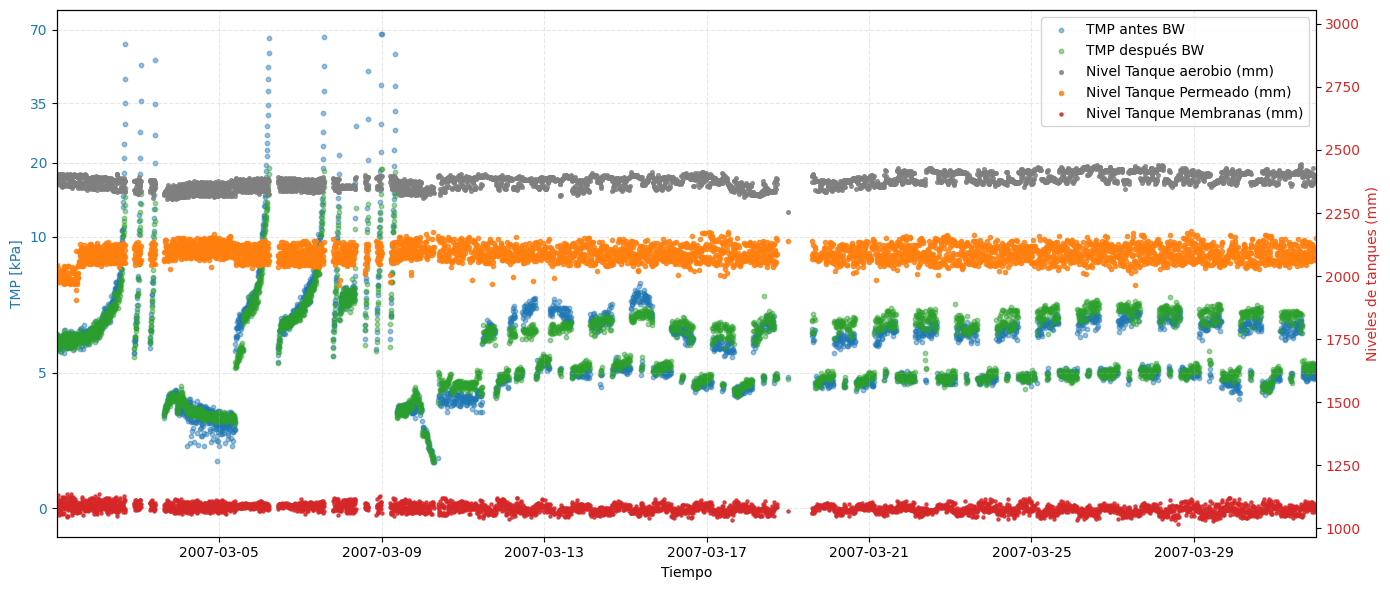

In [ ]:
import matplotlib.pyplot as plt

df = df_outlier.copy()
fecha_min, fecha_max = df['Date'].min(), df['Date'].max()

# ─── Figura y eje izquierdo ───────────────────────────────────────────────
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.scatter(df['Date'], -df['TMP (BBW)'], s=10, alpha=0.45,
            label='TMP antes BW',  color='tab:blue')
ax1.scatter(df['Date'], -df['TMP (ABW)'], s=10, alpha=0.45,
            label='TMP después BW', color='tab:green')

# escala symlog para abrir la zona 0-20 kPa
ax1.set_yscale('symlog', linthresh=10, linscale=1)
ax1.set_yticks([0, 5, 10, 20, 35, 70])
ax1.get_yaxis().set_major_formatter('{x:.0f}')
ax1.set_ylabel('TMP [kPa]', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# ─── Eje derecho: tiempo de ciclo ──────────────────────────────────'', 'Nivel Tanque Permeado (mm)'───────
ax2 = ax1.twinx()
ax2.scatter(df['Date'], df['Nivel Tanque aerobio (mm)'], s=7, alpha=0.8,color='tab:grey', label='Nivel Tanque aerobio (mm)')
ax2.scatter(df['Date'], df['Nivel Tanque Permeado (mm)'], s=9, alpha=0.8,color='tab:orange', label='Nivel Tanque Permeado (mm)')
ax2.scatter(df['Date'], df['Nivel Tanque Membranas (mm)'], s=5, alpha=0.8,color='tab:red', label='Nivel Tanque Membranas (mm)')

ax2.set_ylabel('Niveles de tanques (mm)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(df['Nivel Tanque Membranas (mm)'].min()*0.95,
             df['Nivel Tanque aerobio (mm)'].max()*1.25)

# ─── Eje x, leyenda, rejilla ─────────────────────────────────────────────
ax1.set_xlim(fecha_min, fecha_max)
ax1.set_xlabel('Tiempo')
ax1.grid(True, ls='--', alpha=0.3)

# combinar leyendas de ambos ejes
lines = ax1.get_lines() + ax1.collections   # scatter devuelto como collection
labels = [l.get_label() for l in lines]
lines2 = ax2.get_lines() + ax2.collections
labels2 = [l.get_label() for l in lines2]
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
fig.savefig('TMPvstanques.png', dpi=300)
plt.show()


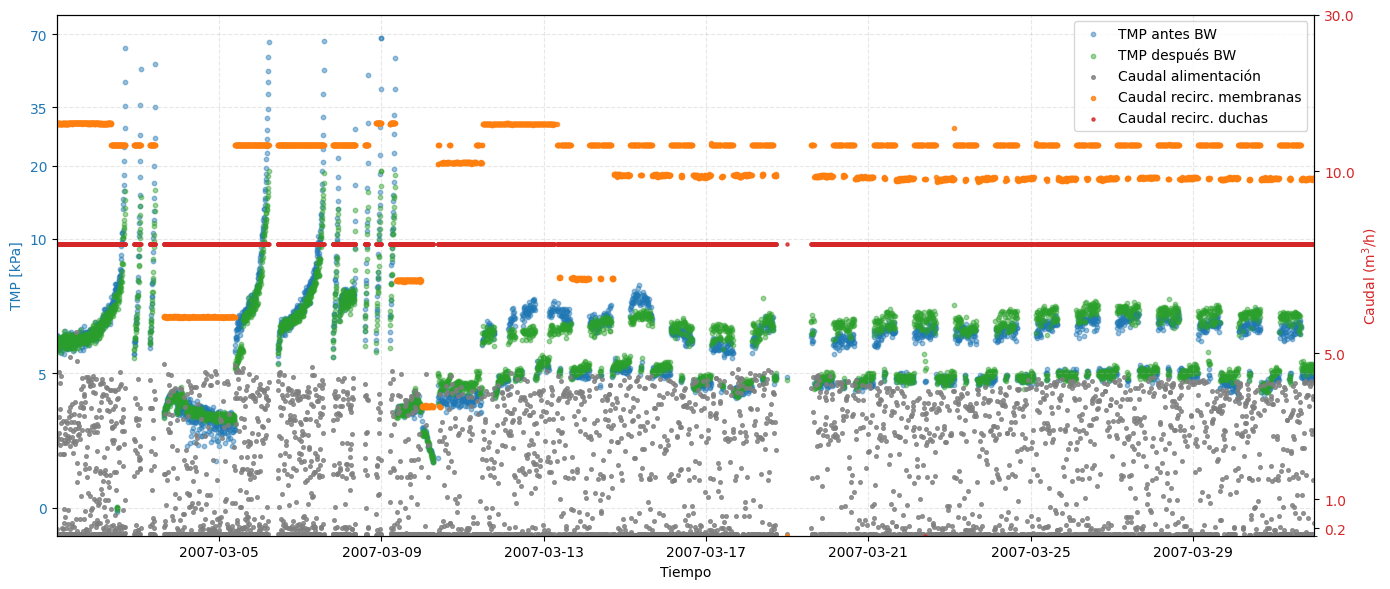

In [ ]:
import matplotlib.pyplot as plt

df = df_outlier.copy()
fecha_min, fecha_max = df['Date'].min(), df['Date'].max()

# ─── Figura y eje izquierdo ───────────────────────────────────────────────
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.scatter(df['Date'], -df['TMP (BBW)'], s=10, alpha=0.45,
            label='TMP antes BW',  color='tab:blue')
ax1.scatter(df['Date'], -df['TMP (ABW)'], s=10, alpha=0.45,
            label='TMP después BW', color='tab:green')

# escala symlog para abrir la zona 0-20 kPa
ax1.set_yscale('symlog', linthresh=10, linscale=1)
ax1.set_yticks([0, 5, 10, 20, 35, 70])
ax1.get_yaxis().set_major_formatter('{x:.0f}')
ax1.set_ylabel('TMP [kPa]', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# ─── Eje derecho: tiempo de ciclo ──────────────────────────────────
ax2 = ax1.twinx()
ax2.scatter(df['Date'], df['Caudal Alimentación (m3/h)'],
            s=7,  alpha=0.8, color='tab:grey',   label='Caudal alimentación')
ax2.scatter(df['Date'], df['Caudal Recirc. Lodo a membranas (m3/h)'],
            s=9,  alpha=0.8, color='tab:orange', label='Caudal recirc. membranas')
ax2.scatter(df['Date'], df['Caudal Recirc. Lodo a duchas (m3/h)'],
            s=5,  alpha=0.8, color='tab:red',    label='Caudal recirc. duchas')

ax2.set_yscale('symlog', linthresh=10, linscale=1)
ax2.set_ylim(0, df['Caudal Recirc. Lodo a membranas (m3/h)'].max()*1.25)
ax2.set_yticks([0.2, 1, 5, 10, 30])
ax2.get_yaxis().set_major_formatter('{x:.1f}')
ax2.set_ylabel('Caudal (m$^{3}$/h)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# ─── Eje x, leyenda, rejilla ─────────────────────────────────────────────
ax1.set_xlim(fecha_min, fecha_max)
ax1.set_xlabel('Tiempo')
ax1.grid(True, ls='--', alpha=0.3)

# combinar leyendas de ambos ejes
lines = ax1.get_lines() + ax1.collections   # scatter devuelto como collection
labels = [l.get_label() for l in lines]
lines2 = ax2.get_lines() + ax2.collections
labels2 = [l.get_label() for l in lines2]
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
fig.savefig('TMPvscaudales.png', dpi=300)
plt.show()


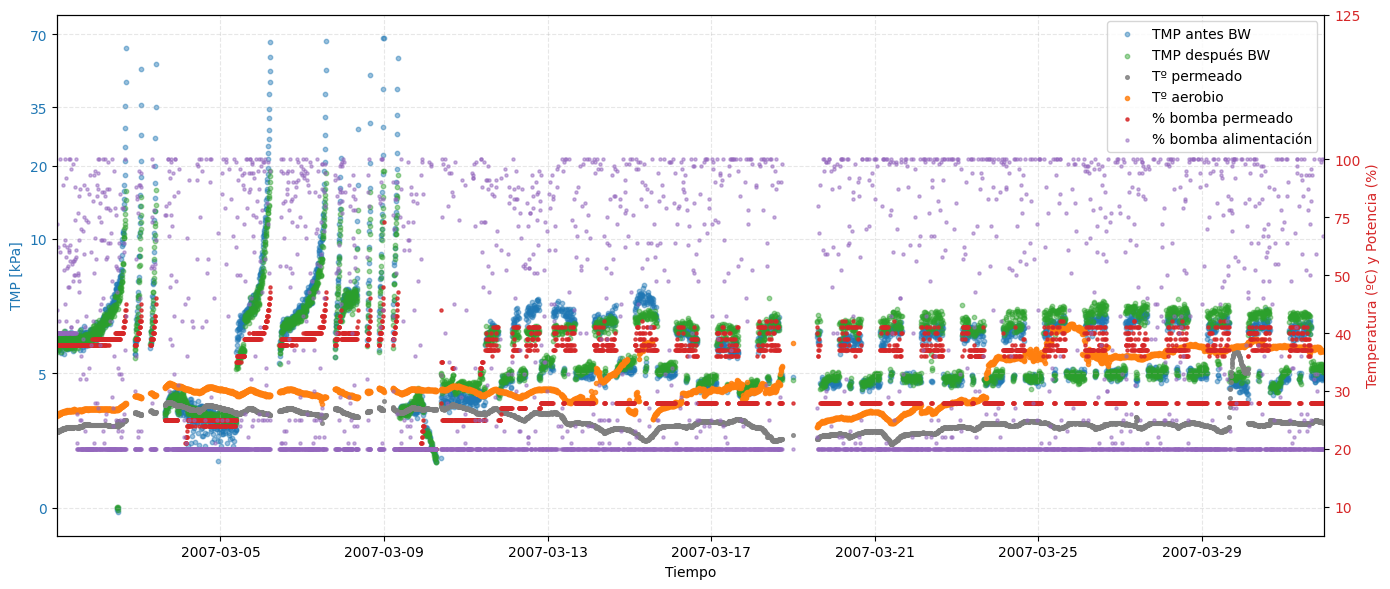

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.scale import FuncScale

df = df_outlier.copy()
fecha_min, fecha_max = df['Date'].min(), df['Date'].max()

# ─── nueva compresión: factor 0.4 en 50-100 ──────────────────────────────
COMP     = 0.4          # 0.4 = un 40 % de la altura lineal
LOW, MID = 50, 100      # tramo a comprimir
SHIFT    = LOW + (MID-LOW)*COMP        # punto donde empieza la parte superior

def fwd(y):
    y = np.asarray(y, dtype=float)
    out = y.copy()
    mask_mid  = (y > LOW) & (y < MID)
    mask_high = y >= MID
    out[mask_mid]  = LOW + (y[mask_mid]-LOW)*COMP
    out[mask_high] = SHIFT + (y[mask_high]-MID)
    return out

def inv(s):
    s = np.asarray(s, dtype=float)
    out = s.copy()
    mask_mid  = (s > LOW) & (s < SHIFT)
    mask_high = s >= SHIFT
    out[mask_mid]  = LOW + (s[mask_mid]-LOW)/COMP
    out[mask_high] = MID + (s[mask_high]-SHIFT)
    return out

# ─── figura con TMP (izq) y temperaturas/potencias (dcha) ────────────────
fig, ax1 = plt.subplots(figsize=(14, 6))

# TMP antes y después BW
ax1.scatter(df['Date'], -df['TMP (BBW)'], s=10, alpha=0.45,
            label='TMP antes BW', color='tab:blue')
ax1.scatter(df['Date'], -df['TMP (ABW)'], s=10, alpha=0.45,
            label='TMP después BW', color='tab:green')
ax1.set_yscale('symlog', linthresh=10); ax1.set_yticks([0,5,10,20,35,70])
ax1.get_yaxis().set_major_formatter('{x:.0f}')
ax1.set_ylabel('TMP [kPa]', color='tab:blue'); ax1.tick_params(axis='y', labelcolor='tab:blue')

# eje derecho
ax2 = ax1.twinx()
ax2.scatter(df['Date'], df['Tº del permeado (ºC)'],            s=7, alpha=0.8, color='tab:grey',   label='Tº permeado')
ax2.scatter(df['Date'], df['Tº del tanque aerobio (ºC)'],      s=9, alpha=0.8, color='tab:orange', label='Tº aerobio')
ax2.scatter(df['Date'], df['% Potencia bomba permeado'],       s=5, alpha=0.8, color='tab:red',    label='% bomba permeado')
ax2.scatter(df['Date'], df['% Potencia bomba aliment.'],       s=5, alpha=0.5, color='tab:purple', label='% bomba alimentación')

ax2.set_yscale(FuncScale(ax2, (fwd, inv)))
ax2.set_ylim(fwd(5), fwd(125))
ax2.set_yticks([10, 20,30,40,50,75,100,125]); ax2.get_yaxis().set_major_formatter('{x:.0f}')
ax2.set_ylabel('Temperatura (ºC) y Potencia (%)', color='tab:red'); ax2.tick_params(axis='y', labelcolor='tab:red')

# eje x, leyenda y salida
ax1.set_xlim(fecha_min, fecha_max); ax1.set_xlabel('Tiempo')
ax1.grid(True, ls='--', alpha=0.3)

h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right')

plt.tight_layout()
plt.savefig('TMP_vs_TempPot.png', dpi=300)
plt.show()


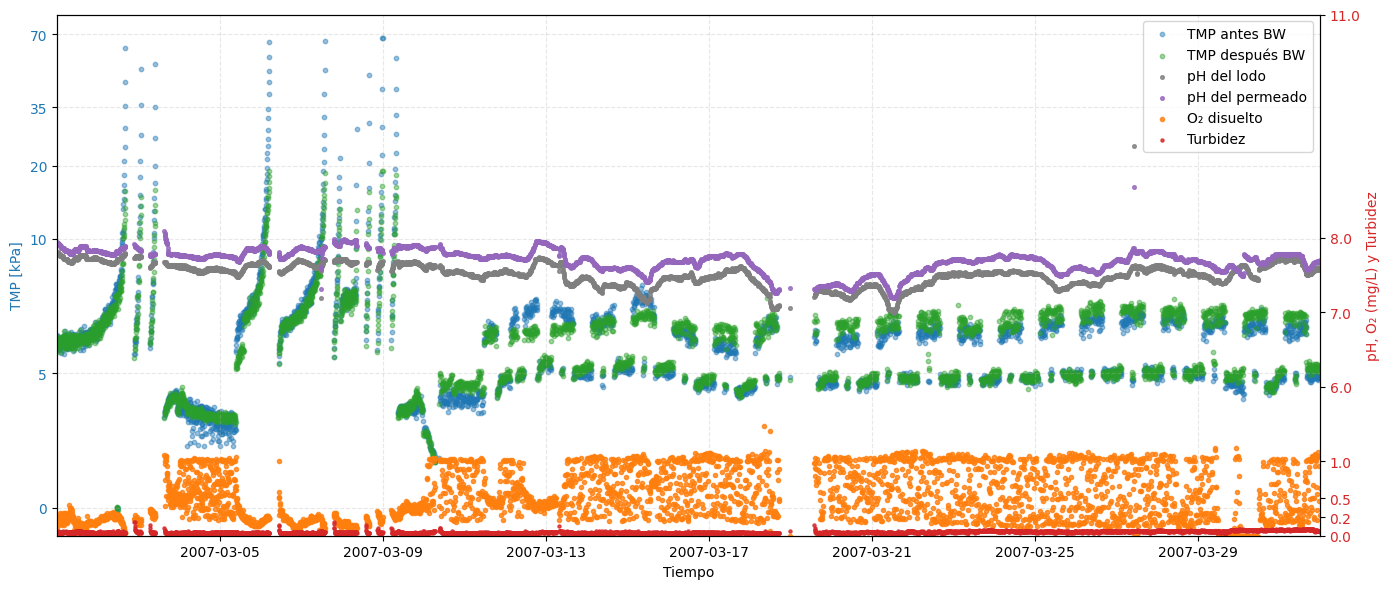

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.scale import FuncScale

df = df_outlier.copy()
fecha_min, fecha_max = df['Date'].min(), df['Date'].max()

# ─── parámetros del tramo comprimido (1–6) ────────────────────────────────
LOW, HIGH = 1, 6          # límites del tramo que se comprime
COMP      = 0.2          # 40 % de la altura lineal
SHIFT     = LOW + (HIGH-LOW)*COMP   # punto donde “aterriza” el valor 6

def fwd(y):
    """valor físico → posición comprimida"""
    y = np.asarray(y, dtype=float)
    out = y.copy()
    mid  = (y > LOW) & (y < HIGH)
    high = y >= HIGH
    out[mid]  = LOW + (y[mid]-LOW)*COMP
    out[high] = SHIFT + (y[high]-HIGH)
    return out

def inv(s):
    """posición comprimida → valor físico (para las etiquetas)"""
    s = np.asarray(s, dtype=float)
    out = s.copy()
    mid  = (s > LOW) & (s < SHIFT)
    high = s >= SHIFT
    out[mid]  = LOW + (s[mid]-LOW)/COMP
    out[high] = HIGH + (s[high]-SHIFT)
    return out

# ─── figura ───────────────────────────────────────────────────────────────
fig, ax1 = plt.subplots(figsize=(14, 6))

# TMP antes / después de BW (eje izq)
ax1.scatter(df['Date'], -df['TMP (BBW)'], s=10, alpha=0.45,
            label='TMP antes BW',  color='tab:blue')
ax1.scatter(df['Date'], -df['TMP (ABW)'], s=10, alpha=0.45,
            label='TMP después BW', color='tab:green')

ax1.set_yscale('symlog', linthresh=10)
ax1.set_yticks([0,5,10,20,35,70]); ax1.get_yaxis().set_major_formatter('{x:.0f}')
ax1.set_ylabel('TMP [kPa]', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# -------- eje derecho con escala comprimida ------------------------------
ax2 = ax1.twinx()
ax2.scatter(df['Date'], df['pH del lodo'],              s=7, alpha=0.8,
            color='tab:grey',   label='pH del lodo')
ax2.scatter(df['Date'], df['pH del Permeado'],          s=7, alpha=0.8,
            color='tab:purple', label='pH del permeado')
ax2.scatter(df['Date'], df['Oxígeno disuelto (mg/l)'],  s=9, alpha=0.8,
            color='tab:orange', label='O₂ disuelto')
ax2.scatter(df['Date'], df['Turbidez (NTU)'],           s=5, alpha=0.8,
            color='tab:red',    label='Turbidez')

# aplicar la escala
ax2.set_yscale(FuncScale(ax2, (fwd, inv)))
ax2.set_ylim(fwd(0), fwd(11))                 # rango total 0–8
ax2.set_yticks([0, 0.25, 0.5, 1, 6, 7, 8,11])
ax2.get_yaxis().set_major_formatter('{x:.1f}')
ax2.set_ylabel('pH, O₂ (mg/L) y Turbidez', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# eje x, leyenda, rejilla
ax1.set_xlim(fecha_min, fecha_max)
ax1.set_xlabel('Tiempo')
ax1.grid(True, ls='--', alpha=0.3)

h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right')

plt.tight_layout()
plt.savefig('TMP_vs_pH_O2_Turbidez.png', dpi=300)
plt.show()

## Diferencias temporales
En esta subsección están todos los gráficos relacionados con las variables temporales

*   Porcentaje de desfase
*   Tiempos de ciclo
*   Tiempos de desfase y $\Delta t$




### Porcentaje de desfase
En este grafico se muestra el procentaje de datos que poseen un desfase superior a determinados umbrales

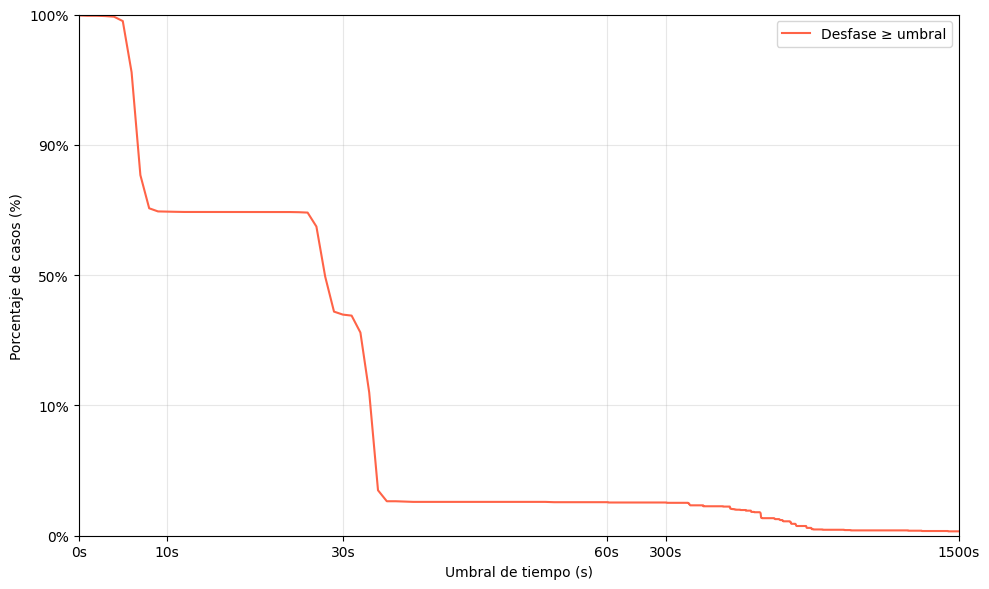

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.scale import FuncScale

# --- datos y parámetros comunes ----------------------------------------
umbrales = np.arange(0, 1501, 1)
n = len(df_marzo)
MAX = 1500.0
TH = 60.0  # umbral para x

# --- funciones de transformación X --------------------------------------
def forward_x(x):
    x = np.asarray(x, dtype=float)
    out = np.empty_like(x)
    low  = x <= TH
    high = x >  TH
    out[low]  = (x[low] / TH) * 0.6
    out[high] = 0.6 + ((x[high] - TH) / (MAX - TH)) * 0.4
    return out

def inverse_x(s):
    s = np.asarray(s, dtype=float)
    out = np.empty_like(s)
    low  = s <= 0.6
    high = s >  0.6
    out[low]  = (s[low] / 0.6) * TH
    out[high] = TH + ((s[high] - 0.6) / 0.4) * (MAX - TH)
    return out

# --- funciones de transformación Y --------------------------------------
def forward_y(y):
    y = np.asarray(y, dtype=float)
    out = np.empty_like(y)
    low  = y <= 10
    mid  = (y > 10) & (y < 90)
    high = y >= 90
    out[low]  = (y[low] / 10) * 0.25
    out[mid]  = 0.25 + ((y[mid] - 10) / 80) * 0.5
    out[high] = 0.75 + ((y[high] - 90) / 10) * 0.25
    return out

def inverse_y(s):
    s = np.asarray(s, dtype=float)
    out = np.empty_like(s)
    low  = s <= 0.25
    mid  = (s > 0.25) & (s < 0.75)
    high = s >= 0.75
    out[low]  = (s[low] / 0.25) * 10
    out[mid]  = 10 + ((s[mid] - 0.5) / 0.5) * 80
    out[high] = 90 + ((s[high] - 0.75) / 0.25) * 10
    return out

# --- Código 1: gráfico para Desfase ≥ umbral -----------------------------
pct_desfase = np.array([(df_marzo["Desfase"] >= u).sum() for u in umbrales]) / n * 100

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(umbrales, pct_desfase, '-', color='tomato', label='Desfase ≥ umbral')

# aplicar escalas
ax.set_xscale(FuncScale(ax, (forward_x, inverse_x)))
ax.set_yscale(FuncScale(ax, (forward_y, inverse_y)))

# etiquetas X en segundos
xticks = [0, 10, 30, 60, 300, 1500]
ax.set_xticks(xticks)
ax.set_xticklabels([f"{t}s" for t in xticks])

# etiquetas Y en porcentaje real
yticks = [0, 10, 50, 90, 100]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter('{x:.0f}%')

ax.set_xlim(0, MAX)
ax.set_ylim(0, 100)
ax.set_xlabel("Umbral de tiempo (s)")
ax.set_ylabel("Porcentaje de casos (%)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



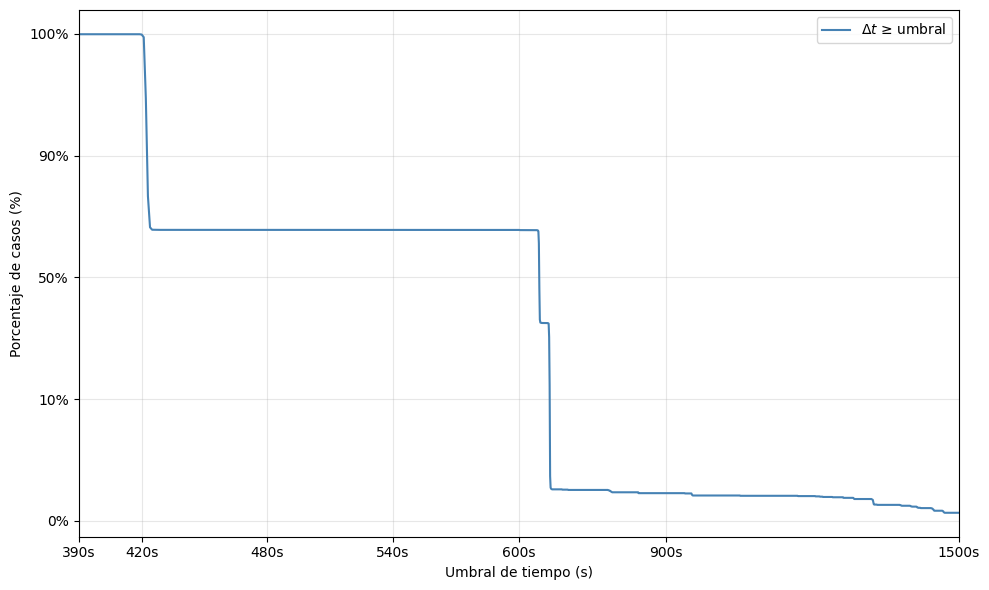

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.scale import FuncScale

# --- prepara tus datos ----------------------------------------
umbrales = np.arange(0, 1501, 1)
n = len(df_marzo)
pct_deltat = np.array([(df_marzo["Delta_t"] >= u).sum() for u in umbrales]) / n * 100

# --- parámetros para escalado X ------------------------------------------
MIN_X, FOCUS_L, FOCUS_H, MAX_X = 390.0, 390.0, 600.0, 1500.0

# --- funciones de transformación X ---------------------------------------
def forward_x(x):
    x = np.asarray(x, dtype=float)
    out = np.empty_like(x)
    # todo < MIN_X lo recortamos a 0
    below = x <= MIN_X
    # 390–600 → 0–0.5
    mid   = (x > MIN_X) & (x <= FOCUS_H)
    # 600–1500 → 0.5–1.0
    above = x > FOCUS_H

    out[below] = 0.0
    out[mid]   = ((x[mid] - FOCUS_L) / (FOCUS_H - FOCUS_L)) * 0.5
    out[above] = 0.5 + ((x[above] - FOCUS_H) / (MAX_X - FOCUS_H)) * 0.5
    return out

def inverse_x(s):
    s = np.asarray(s, dtype=float)
    out = np.empty_like(s)
    low   = s <= 0.5
    high  = s >  0.5

    # 0–0.5 → 330–600
    out[low]  = FOCUS_L + (s[low] / 0.5) * (FOCUS_H - FOCUS_L)
    # 0.5–1.0 → 600–1500
    out[high] = FOCUS_H + ((s[high] - 0.5) / 0.5) * (MAX_X - FOCUS_H)
    return out

# --- escala Y (igual que antes) -----------------------------------------
def forward_y(y):
    y = np.asarray(y, dtype=float); out = np.empty_like(y)
    low  = y <= 10
    mid  = (y > 10) & (y < 90)
    high = y >= 90
    out[low]  = (y[low] / 10) * 0.25
    out[mid]  = 0.25 + ((y[mid] - 10) / 80) * 0.5
    out[high] = 0.75 + ((y[high] - 90) / 10) * 0.25
    return out

def inverse_y(s):
    s = np.asarray(s, dtype=float); out = np.empty_like(s)
    low  = s <= 0.25
    mid  = (s > 0.25) & (s < 0.75)
    high = s >= 0.75
    out[low]  = (s[low] / 0.25) * 10
    out[mid]  = 10 + ((s[mid] - 0.5) / 0.5) * 80
    out[high] = 90 + ((s[high] - 0.75) / 0.25) * 10
    return out

# --- plotea --------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(umbrales, pct_deltat, '-', color='steelblue', label=r'$\Delta t$ ≥ umbral')

# aplica las dos escalas
ax.set_xscale(FuncScale(ax, (forward_x, inverse_x)))
ax.set_yscale(FuncScale(ax, (forward_y, inverse_y)))

# xticks en segundos (etiquetas reales)
ticks_x = [390, 420, 480, 540, 600, 900, 1500]
ax.set_xticks(ticks_x)
ax.set_xticklabels([f"{int(t)}s" for t in ticks_x])
ax.set_xlim(MIN_X, MAX_X)

# yticks en porcentaje
yticks = [0, 10, 50, 90, 100]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter('{x:.0f}%')

ax.set_xlabel("Umbral de tiempo (s)")
ax.set_ylabel("Porcentaje de casos (%)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Tiempos de ciclo

En este grafico, se muestra las distintas configuraciones y duraciones de los ciclos operativos

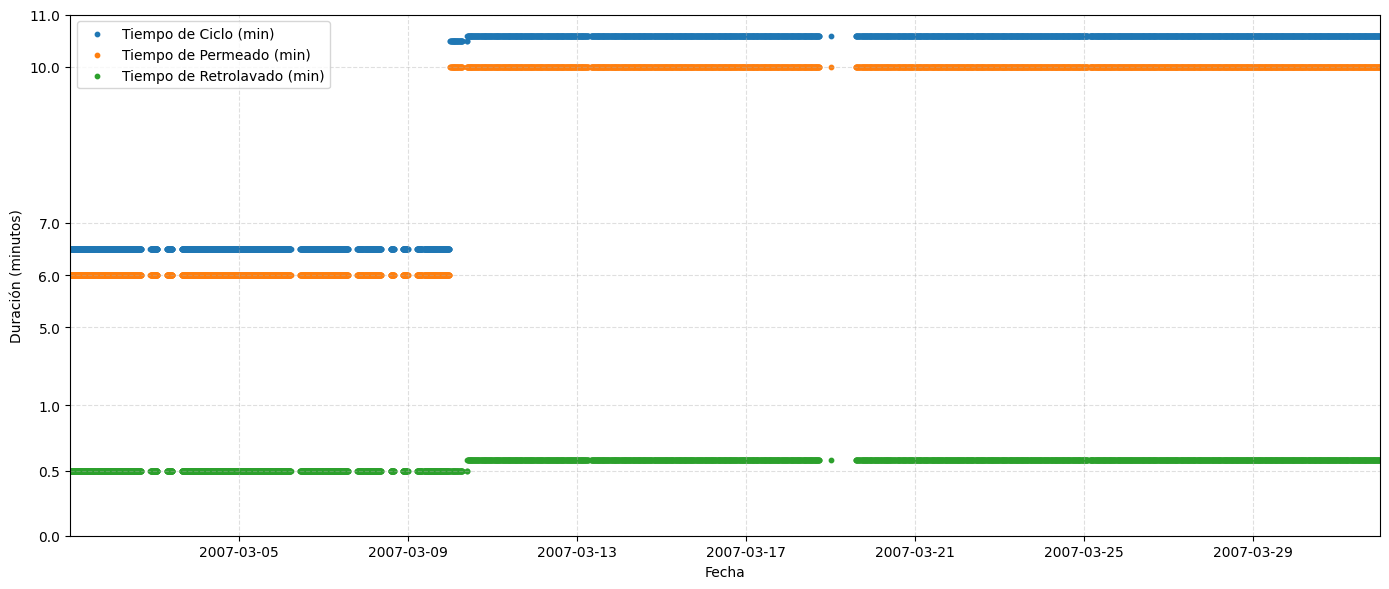

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.scale import FuncScale

t_cycle = df['Tiempo de ciclo (s)'] / 60
t_perm  = df['Tiempo de permeado (s)'] / 60
t_bw    = df['Tiempo de BW (s)'] / 60
fecha_min, fecha_max = df['Date'].min(), df['Date'].max()

# --- funciones de transformación Y ---------------------------------------
MIN_Y, A, B, MAX_Y = 0.0, 1.0, 5.0, 11.0
# 0–1 min → 0–0.25, 1–5 → 0.25–0.40, 5–11 → 0.40–1.0

def forward_y(y):
    y = np.asarray(y, dtype=float)
    out = np.empty_like(y)
    low  = y <= A
    mid  = (y > A) & (y <= B)
    high = y > B
    out[low]  = (y[low] / A) * 0.25
    out[mid]  = 0.25 + ((y[mid] - A) / (B - A)) * 0.15
    out[high] = 0.40 + ((y[high] - B) / (MAX_Y - B)) * 0.60
    return out

def inverse_y(s):
    s = np.asarray(s, dtype=float)
    out = np.empty_like(s)
    low  = s <= 0.25
    mid  = (s > 0.25) & (s <= 0.40)
    high = s > 0.40
    out[low]  = (s[low] / 0.25) * A
    out[mid]  = A + ((s[mid] - 0.25) / 0.15) * (B - A)
    out[high] = B + ((s[high] - 0.40) / 0.60) * (MAX_Y - B)
    return out

# --- plot --------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 6))

ax.scatter(df['Date'], t_cycle, label='Tiempo de Ciclo (min)',     s=10)
ax.scatter(df['Date'], t_perm,  label='Tiempo de Permeado (min)', s=10)
ax.scatter(df['Date'], t_bw,    label='Tiempo de Retrolavado (min)', s=10)

# aplica escala Y personalizada
ax.set_yscale(FuncScale(ax, (forward_y, inverse_y)))

# ticks Y en minutos reales
yticks = [0, 0.5, 1, 5, 6, 7, 10, 11]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter('{x:.1f}')

ax.set_xlim(fecha_min, fecha_max)
ax.set_xlabel('Fecha')
ax.set_ylabel('Duración (minutos)')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()

### Tiempos de desfase y $\Delta t$

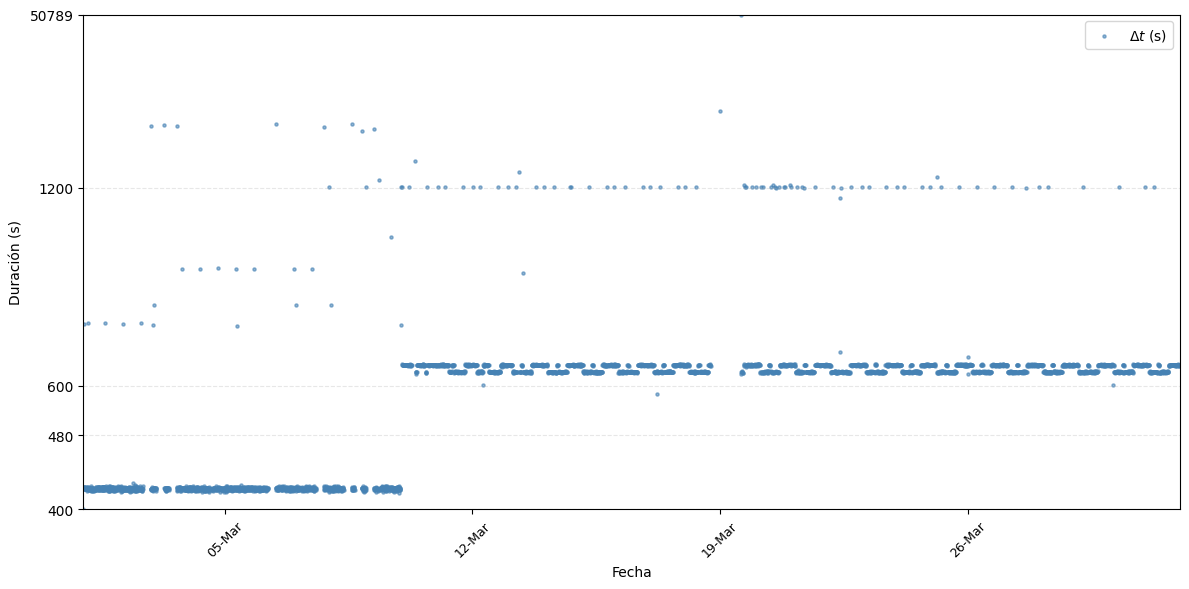

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.scale import FuncScale

# Datos
dates = df_marzo['Date']
y_orig = df_marzo['Delta_t'].values   # Δt en segundos
fecha_min, fecha_max = dates.min(), dates.max()
MAX_Y = y_orig.max()

# Parámetros de bloques en segundos
L1, U1 = 400.0, 480.0
L2, U2 = 480.0, 600.0
L3, U3 = 600.0, 1200.0

# Nuevas proporciones: 15%, 10%, 40%, 35% → segmentos [0–0.15], [0.15–0.25], [0.25–0.65], [0.65–1.0]
def forward_y(v):
    v_c = np.asarray(v, dtype=float)
    out = np.empty_like(v_c)
    m0 = v_c <= L1
    m1 = (v_c > L1) & (v_c <= U1)
    m2 = (v_c > L2) & (v_c <= U2)
    m3 = (v_c > L3) & (v_c <= U3)
    m4 = v_c > U3

    out[m0] = 0.0
    out[m1] = ((v_c[m1] - L1) / (U1 - L1)) * 0.15
    out[m2] = 0.15 + ((v_c[m2] - L2) / (U2 - L2)) * 0.10
    out[m3] = 0.25 + ((v_c[m3] - L3) / (U3 - L3)) * 0.40
    out[m4] = 0.65 + ((v_c[m4] - U3) / (MAX_Y - U3)) * 0.35
    return out

def inverse_y(s):
    s = np.asarray(s, dtype=float)
    out = np.empty_like(s)
    s1 = s <= 0.15
    s2 = (s > 0.15) & (s <= 0.25)
    s3 = (s > 0.25) & (s <= 0.65)
    s4 = s > 0.65

    out[s1] = L1 + (s[s1] / 0.15) * (U1 - L1)
    out[s2] = L2 + ((s[s2] - 0.15) / 0.10) * (U2 - L2)
    out[s3] = L3 + ((s[s3] - 0.25) / 0.40) * (U3 - L3)
    out[s4] = U3 + ((s[s4] - 0.65) / 0.35) * (MAX_Y - U3)
    return out

# Añadir jitter ligero para separar puntos coincidentes
np.random.seed(0)
jitter = np.random.normal(0, 1, size=y_orig.shape)  # ±1s jitter
y_jit = np.clip(y_orig + jitter, 0, MAX_Y)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(dates, y_jit, s=5, alpha=0.6, color='steelblue', label=r'$\Delta t$ (s)')

# Escala Y personalizada
ax.set_yscale(FuncScale(ax, (forward_y, inverse_y)))
ax.set_ylim(L1, MAX_Y)

# Ticks en valores clave
ticks_y = [L1, U1, U2, U3, MAX_Y]
ax.set_yticks(ticks_y)
ax.get_yaxis().set_major_formatter('{x:.0f}')

# Formato X semanal
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.tick_params(axis='x', rotation=45, labelsize=9)

# Grid horizontal limpio
ax.grid(which='major', axis='y', linestyle='--', alpha=0.3)
ax.grid(False, axis='x')

# Etiquetas y leyenda
ax.set_xlim(fecha_min, fecha_max)
ax.set_xlabel('Fecha')
ax.set_ylabel('Duración (s)')
ax.legend()
plt.tight_layout()
plt.show()


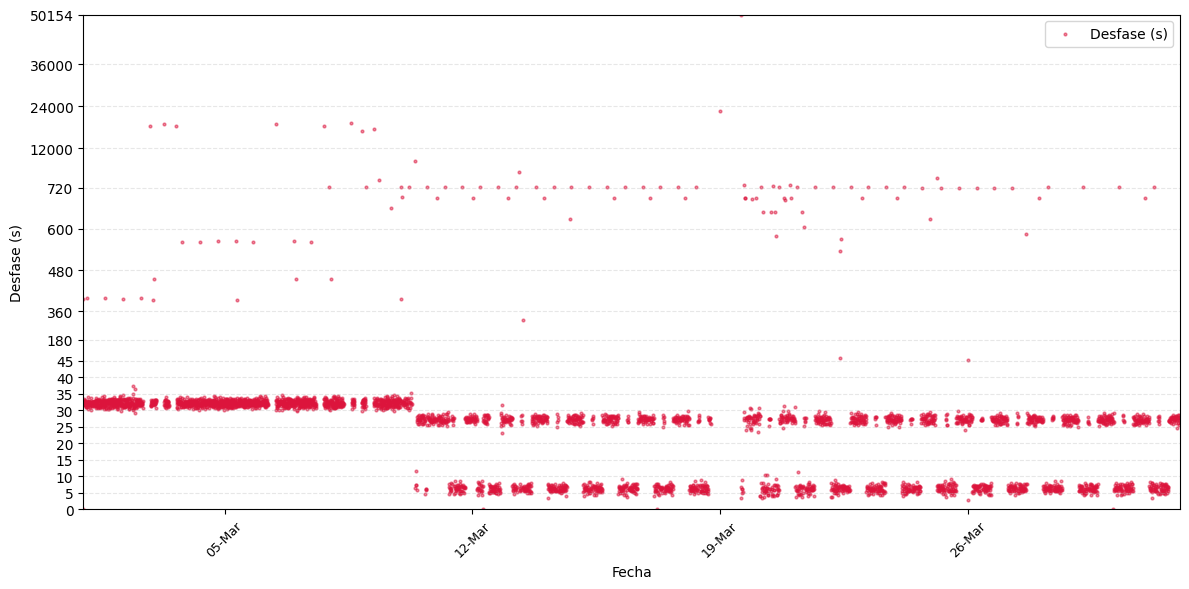

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.scale import FuncScale

# Datos
dates   = df_marzo['Date']
y_orig  = df_marzo['Desfase'].values  # en segundos
fecha_min, fecha_max = dates.min(), dates.max()
MAX_Y   = y_orig.max()

# Nuevos límites para cada bloque (s)
L1, U1 =   0.0,   45.0   # 0–45 s → 30 %
L2, U2 =  45.0,  360.0   # 45–360 s → 10 %
L3, U3 = 360.0,  720.0   # 360–720 s → 25 %
# >720 s → 35 %

# Funciones de mapeo Y
def forward_y(v):
    v = np.asarray(v, dtype=float)
    out = np.empty_like(v)
    m0 = v <= L1
    m1 = (v >  L1) & (v <= U1)
    m2 = (v >  L2) & (v <= U2)
    m3 = (v >  L3) & (v <= U3)
    m4 = v >  U3

    out[m0] = 0.0
    out[m1] = ((v[m1] - L1) / (U1 - L1)) * 0.30
    out[m2] = 0.30 + ((v[m2] - L2) / (U2 - L2)) * 0.10
    out[m3] = 0.40 + ((v[m3] - L3) / (U3 - L3)) * 0.25
    out[m4] = 0.65 + ((v[m4] - U3) / (MAX_Y - U3)) * 0.35
    return out

def inverse_y(s):
    s = np.asarray(s, dtype=float)
    out = np.empty_like(s)
    s1 = s <= 0.30
    s2 = (s >  0.30) & (s <= 0.40)
    s3 = (s >  0.40) & (s <= 0.65)
    s4 = s >  0.65

    out[s1] = L1 + (s[s1] / 0.30) * (U1 - L1)
    out[s2] = L2 + ((s[s2] - 0.30) / 0.10) * (U2 - L2)
    out[s3] = L3 + ((s[s3] - 0.40) / 0.25) * (U3 - L3)
    out[s4] = U3 + ((s[s4] - 0.65) / 0.35) * (MAX_Y - U3)
    return out

# Jitter suave para separar puntos coincidentes
np.random.seed(42)
jitter = np.random.normal(0, 0.5, size=y_orig.shape)
y_jit = np.clip(y_orig + jitter, 0, MAX_Y)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(dates, y_jit, s=4, alpha=0.5, color='crimson', label='Desfase (s)')

# Aplicar escala Y personalizada
ax.set_yscale(FuncScale(ax, (forward_y, inverse_y)))
ax.set_ylim(L1, MAX_Y)

# Ticks en los límites de cada bloque y el máximo
ticks_y = [L1, 5, 10, 15, 20, 25, 30, 35, 40, U1, 180, U2, 480, 600, U3, 12000, 24000, 36000, MAX_Y]
ax.set_yticks(ticks_y)
ax.get_yaxis().set_major_formatter('{x:.0f}')

# Formato eje X (tick semanal los lunes)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.tick_params(axis='x', rotation=45, labelsize=9)

# Grid horizontal limpio
ax.grid(which='major', axis='y', linestyle='--', alpha=0.3)
ax.grid(False, axis='x')

# Etiquetas y título
ax.set_xlim(fecha_min, fecha_max)
ax.set_xlabel('Fecha')
ax.set_ylabel('Desfase (s)')
ax.legend()
plt.tight_layout()
plt.show()
